In [1]:

##Datasets for Historical Currency from yfinance: CAD->USD, CAD->INR, CAD->GBP

##Datasets for Historical StockMarket info from yfinance: US (Nifty), India (sensex), UK (NIKKEI)

##Datasets for Inflation (Monthly/Quarterly) from: https://fred.stlouisfed.org/

##Datasets for Canada GDP: https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/monthlygrossdomesticproductbygrossvalueadded


In [116]:
## Import Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import time
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import pickle

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Import data file

## Exchange Rate Information
data_inr = pd.read_csv("../Data/INR_CAD_hist_2004_28_05_2021.csv") # CAD to Indian Rupees
data_usd = pd.read_csv('../Data/USD_CAD_hist_2004_28_05_2021.csv') ## CAD to USD Dollars
data_gbp = pd.read_csv("../Data/GBP_CAD_hist_2004_28_05_2021.csv") # CAD to British Pounds

## Stock Market Information
ind_sensex = pd.read_csv('../Data/india_sensex_formodelling.csv') ## daily-> daily
usd_nifty = pd.read_csv('../Data/nifty_modelling.csv') ## daily-> daily
gbp_lse = pd.read_csv("../Data/LSE_formodelling.csv") # CAD to Indian Rupees
can_tse = pd.read_csv("../Data/tse_modelling.csv")

## Inflation Information
ind_inflation = pd.read_csv('../Data/indiainflation.csv') ## monthly -> daily
usd_inflation = pd.read_csv('../Data/usinflation.csv') ## monthly -> daily
gbp_inflation = pd.read_csv('../Data/uk_cpi.csv') ## monthly -> daily
can_inflation = pd.read_csv('../Data/canadainflation.csv') ## CAD to USD Dollars

## GDP Information (additional feature for all)
can_gdp = pd.read_csv('../Data/canada_gdp2.csv')


## check data shapes
print('data_inr' + str(data_inr.shape))
print('data_usd ' + str(data_usd.shape))
print('data_gbp ' + str(data_gbp.shape))

print('ind_sensex' + str(ind_sensex.shape))
print('usd_nifty' + str(usd_nifty.shape))
print('gbp_lse' + str(gbp_lse.shape))
print('can_tse' + str(can_tse.shape))

print('ind_inflation' + str(ind_inflation.shape))
print('usd_inflation' + str(usd_inflation.shape))
print('gbp_inflation' + str(gbp_inflation.shape))
print('can_inflation' + str(can_inflation.shape))

print('can_gdp' + str(can_gdp.shape))

data_inr(4651, 5)
data_usd (4631, 5)
data_gbp (4651, 5)
ind_sensex(4411, 3)
usd_nifty(4410, 2)
gbp_lse(4505, 2)
can_tse(4469, 2)
ind_inflation(214, 2)
usd_inflation(4546, 2)
gbp_inflation(214, 2)
can_inflation(288, 2)
can_gdp(213, 2)


In [4]:
## Set Date Column as index for all

data_inr.Date = pd.to_datetime(data_inr.Date, dayfirst = True)
data_inr.set_index("Date", inplace=True)

data_usd.Date = pd.to_datetime(data_usd.Date, dayfirst = True)
data_usd.set_index("Date", inplace=True)

data_gbp.Date = pd.to_datetime(data_gbp.Date, dayfirst = True)
data_gbp.set_index("Date", inplace=True)

ind_sensex.Date = pd.to_datetime(ind_sensex.Date, dayfirst = True)
ind_sensex.set_index("Date", inplace=True)

usd_nifty.Date = pd.to_datetime(usd_nifty.Date, dayfirst = True)
usd_nifty.set_index("Date", inplace=True)

gbp_lse.Date = pd.to_datetime(gbp_lse.Date, dayfirst = True)
gbp_lse.set_index("Date", inplace=True)

can_tse.Date = pd.to_datetime(can_tse.Date, dayfirst = True)
can_tse.set_index("Date", inplace=True)

ind_inflation.Date = pd.to_datetime(ind_inflation.Date, dayfirst = True)
ind_inflation.set_index("Date", inplace=True)

usd_inflation.Date = pd.to_datetime(usd_inflation.Date, dayfirst = True)
usd_inflation.set_index("Date", inplace=True)

gbp_inflation.Date = pd.to_datetime(gbp_inflation.Date, dayfirst = True)
gbp_inflation.set_index("Date", inplace=True)

can_inflation.Date = pd.to_datetime(can_inflation.Date, dayfirst = True)
can_inflation.set_index("Date", inplace=True)

can_gdp.Date = pd.to_datetime(can_gdp.Date, dayfirst = True)
can_gdp.set_index("Date", inplace=True)

In [5]:
## Monthly/Quarterly Data -> Daily and fill missing values using forward fill imputation

data_usd_daily = data_usd.resample('B').mean().replace(0,np.nan)
data_usd_daily = data_usd_daily.fillna(method='ffill')

data_inr_daily = data_inr.resample('B').mean().replace(0,np.nan)
data_inr_daily = data_inr_daily.fillna(method='ffill')

data_gbp_daily = data_gbp.resample('B').mean().replace(0,np.nan)
data_gbp_daily = data_gbp_daily.fillna(method='ffill')

ind_sensex_daily = ind_sensex.resample('B').mean().replace(0,np.nan)
ind_sensex_daily = ind_sensex_daily.fillna(method='ffill')

usd_nifty_daily = usd_nifty.resample('B').mean().replace(0,np.nan)
usd_nifty_daily = usd_nifty_daily.fillna(method='ffill')

gbp_lse_daily = gbp_lse.resample('B').mean().replace(0,np.nan)
gbp_lse_daily = gbp_lse_daily.fillna(method='ffill')

can_tse_daily = can_tse.resample('B').mean().replace(0,np.nan)
can_tse_daily = can_tse_daily.fillna(method='ffill')

ind_inflation = ind_inflation.astype(float).replace(0,np.nan).replace('.',0)
ind_inflation_daily = ind_inflation.resample('B').mean()
ind_inflation_daily = ind_inflation_daily.fillna(method='ffill')

usd_inflation = usd_inflation.replace(0,np.nan).replace('.',0)
usd_inflation = usd_inflation.astype(float)
usd_inflation_daily = usd_inflation.resample('B').mean()
usd_inflation_daily = usd_inflation_daily.fillna(method='ffill')

gbp_inflation = gbp_inflation.astype(float).replace(0,np.nan).replace('.',0)
gbp_inflation_daily = gbp_inflation.resample('B').mean()
gbp_inflation_daily = gbp_inflation_daily.fillna(method='ffill')

can_inflation = can_inflation.astype(float).replace(0,np.nan).replace('.',0)
can_inflation_daily = can_inflation.resample('B').mean()
can_inflation_daily = can_inflation_daily.fillna(method='ffill')

can_gdp_daily = can_gdp.resample('B').mean().replace(0,np.nan)
can_gdp_daily = can_gdp_daily.fillna(method='ffill')

## check for nay null/missing values
print(data_usd_daily.isnull().sum())
print(data_inr_daily.isnull().sum())
print(data_gbp_daily.isnull().sum())
print(ind_sensex_daily.isnull().sum())
print(usd_nifty_daily.isnull().sum())
print(gbp_lse_daily.isnull().sum())
print(can_tse_daily.isnull().sum())
print(ind_inflation_daily.isnull().sum())
print(usd_inflation_daily.isnull().sum())
print(gbp_inflation_daily.isnull().sum())
print(can_inflation_daily.isnull().sum())
print(can_gdp_daily.isnull().sum())

usd_open     0
usd_high     0
usd_low      0
usd_close    0
dtype: int64
inr_open     0
inr_high     0
inr_low      0
inr_close    0
dtype: int64
gbp_open     0
gbp_high     0
gbp_low      0
gbp_close    0
dtype: int64
india_close_sensex       0
Unnamed: 2            4631
dtype: int64
nifty_close    0
dtype: int64
lse_close    0
dtype: int64
tse_close    0
dtype: int64
indinflation    0
dtype: int64
usinflation    0
dtype: int64
uk_inflation    0
dtype: int64
canada_inflation    0
dtype: int64
can_gdp    0
dtype: int64


In [6]:
## check if the shape is consistent - daily
print(data_usd_daily.shape)
print(data_inr_daily.shape)
print(data_gbp_daily.shape)
print(ind_sensex_daily.shape)
print(usd_nifty_daily.shape)
print(gbp_lse_daily.shape)
print(can_tse_daily.shape)
print(ind_inflation_daily.shape)
print(usd_inflation_daily.shape)
print(gbp_inflation_daily.shape)
print(can_inflation_daily.shape)
print(can_gdp_daily.shape)

(4631, 4)
(4631, 4)
(4631, 4)
(4631, 2)
(4631, 1)
(4631, 1)
(4630, 1)
(4631, 1)
(4631, 1)
(4631, 1)
(4631, 1)
(4631, 1)


In [7]:
## Creating a dataframe for daily data
daily_data = pd.concat([data_inr_daily, data_usd_daily, data_gbp_daily, ind_sensex_daily, usd_nifty_daily, gbp_lse_daily, can_tse_daily, ind_inflation_daily, usd_inflation_daily, gbp_inflation_daily, can_inflation_daily, can_gdp_daily], axis=1)

In [8]:
daily_data = daily_data.astype(float)

In [9]:
daily_data.drop(['Unnamed: 2'],axis=1,inplace=True)

In [10]:
daily_data.columns

Index(['inr_open', 'inr_high', 'inr_low', 'inr_close', 'usd_open', 'usd_high',
       'usd_low', 'usd_close', 'gbp_open', 'gbp_high', 'gbp_low', 'gbp_close',
       'india_close_sensex', 'nifty_close', 'lse_close', 'tse_close',
       'indinflation', 'usinflation', 'uk_inflation', 'canada_inflation',
       'can_gdp'],
      dtype='object')

In [11]:
data_usd_monthly = data_usd.resample('M').mean().replace(0,np.nan)
data_usd_monthly = data_usd_monthly.fillna(method='ffill')

data_inr_monthly = data_inr.resample('M').mean().replace(0,np.nan)
data_inr_monthly = data_inr_monthly.fillna(method='ffill')

data_gbp_monthly = data_gbp.resample('M').mean().replace(0,np.nan)
data_gbp_monthly = data_gbp_monthly.fillna(method='ffill')

ind_sensex_monthly = ind_sensex.resample('M').mean().replace(0,np.nan)
ind_sensex_monthly = ind_sensex_monthly.fillna(method='ffill')

usd_nifty_monthly = usd_nifty.resample('M').mean().replace(0,np.nan)
usd_nifty_monthly = usd_nifty_monthly.fillna(method='ffill')

gbp_lse_monthly = gbp_lse.resample('M').mean().replace(0,np.nan)
gbp_lse_monthly = gbp_lse_monthly.fillna(method='ffill')

can_tse_monthly = can_tse.resample('M').mean().replace(0,np.nan)
can_tse_monthly = can_tse_monthly.fillna(method='ffill')

ind_inflation = ind_inflation.astype(float).replace(0,np.nan).replace('.',0)
ind_inflation_monthly = ind_inflation.resample('M').mean()
ind_inflation_monthly = ind_inflation_monthly.fillna(method='ffill')

usd_inflation = usd_inflation.replace(0,np.nan).replace('.',0)
usd_inflation = usd_inflation.astype(float)
usd_inflation_monthly = usd_inflation.resample('M').mean()
usd_inflation_monthly = usd_inflation_monthly.fillna(method='ffill')

gbp_inflation = gbp_inflation.astype(float).replace(0,np.nan).replace('.',0)
gbp_inflation_monthly = gbp_inflation.resample('M').mean()
gbp_inflation_monthly = gbp_inflation_monthly.fillna(method='ffill')

can_inflation = can_inflation.astype(float).replace(0,np.nan).replace('.',0)
can_inflation_monthly = can_inflation.resample('M').mean()
can_inflation_monthly = can_inflation_monthly.fillna(method='ffill')

can_gdp = can_gdp.astype(float).replace(0,np.nan).replace('.',0)
can_gdp_monthly = can_gdp.resample('M').mean()
can_gdp_monthly = can_gdp_monthly.fillna(method='ffill')

## check for nay null/missing values
print(data_usd_monthly.isnull().sum())
print(data_inr_monthly.isnull().sum())
print(data_gbp_monthly.isnull().sum())
print(ind_sensex_monthly.isnull().sum())
print(usd_nifty_monthly.isnull().sum())
print(gbp_lse_monthly.isnull().sum())
print(can_tse_monthly.isnull().sum())
print(ind_inflation_monthly.isnull().sum())
print(usd_inflation_monthly.isnull().sum())
print(gbp_inflation_monthly.isnull().sum())
print(can_inflation_monthly.isnull().sum())
print(can_gdp_monthly.isnull().sum())

usd_open     0
usd_high     0
usd_low      0
usd_close    0
dtype: int64
inr_open     0
inr_high     0
inr_low      0
inr_close    0
dtype: int64
gbp_open     0
gbp_high     0
gbp_low      0
gbp_close    0
dtype: int64
india_close_sensex      0
Unnamed: 2            213
dtype: int64
nifty_close    0
dtype: int64
lse_close    0
dtype: int64
tse_close    0
dtype: int64
indinflation    0
dtype: int64
usinflation    0
dtype: int64
uk_inflation    0
dtype: int64
canada_inflation    0
dtype: int64
can_gdp    0
dtype: int64


In [12]:
## check if the shape is consistent - monthly
print(data_usd_monthly.shape)
print(data_inr_monthly.shape)
print(data_gbp_monthly.shape)
print(ind_sensex_monthly.shape)
print(usd_nifty_monthly.shape)
print(gbp_lse_monthly.shape)
print(can_tse_monthly.shape)
print(ind_inflation_monthly.shape)
print(usd_inflation_monthly.shape)
print(gbp_inflation_monthly.shape)
print(can_inflation_monthly.shape)
print(can_gdp_monthly.shape)

(213, 4)
(213, 4)
(213, 4)
(213, 2)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)


In [13]:
## Creating a dataframe for monthly data
monthly_data = pd.concat([data_inr_monthly, data_usd_monthly, data_gbp_monthly, ind_sensex_monthly, usd_nifty_monthly, gbp_lse_monthly, can_tse_monthly, ind_inflation_monthly, usd_inflation_monthly, gbp_inflation_monthly, can_inflation_monthly, can_gdp_monthly], axis=1)

In [14]:
monthly_data = monthly_data.astype(float)

In [15]:
monthly_data.drop(['Unnamed: 2'],axis=1,inplace=True)

In [16]:
monthly_data.columns

Index(['inr_open', 'inr_high', 'inr_low', 'inr_close', 'usd_open', 'usd_high',
       'usd_low', 'usd_close', 'gbp_open', 'gbp_high', 'gbp_low', 'gbp_close',
       'india_close_sensex', 'nifty_close', 'lse_close', 'tse_close',
       'indinflation', 'usinflation', 'uk_inflation', 'canada_inflation',
       'can_gdp'],
      dtype='object')

## Monthly Forecast using fbprophet (USD - INR - GBP)

In [17]:
## Keep monthly_data as backup dataframe
df_monthly = monthly_data.copy()

In [18]:
## Select required columns

df_monthly = df_monthly[['inr_close','usd_close','gbp_close',
            'india_close_sensex', 'nifty_close', 'lse_close', 'tse_close',
       'indinflation', 'usinflation', 'uk_inflation', 'canada_inflation',
       'can_gdp']]

In [19]:
## Feature Engineer - previous month highest closing price

sensexIndia = MinMaxScaler()
df_monthly['scaled_sensex_close'] = sensexIndia.fit_transform(df_monthly[['india_close_sensex']])
niftyUS = MinMaxScaler()
df_monthly['scaled_nifty_close'] = niftyUS.fit_transform(df_monthly[['nifty_close']])
lseUK = MinMaxScaler()
df_monthly['scaled_lse_close'] = lseUK.fit_transform(df_monthly[['lse_close']])
tseCanada = MinMaxScaler()
df_monthly['scaled_india_close'] = tseCanada.fit_transform(df_monthly[['tse_close']])

In [20]:
## Feature Engineer - Manually Normalize inflation, gdp and create a differenced column for inflation rates (can use MinMax/Standard scalar)

df_monthly['norm_indinflation'] = (df_monthly['indinflation']-df_monthly['indinflation'].mean())/df_monthly['indinflation'].std()
df_monthly['norm_usinflation'] = (df_monthly['usinflation']-df_monthly['usinflation'].mean())/df_monthly['usinflation'].std()
df_monthly['norm_uk_inflation'] = (df_monthly['uk_inflation']-df_monthly['uk_inflation'].mean())/df_monthly['uk_inflation'].std()
df_monthly['norm_canada_inflation'] = (df_monthly['canada_inflation']-df_monthly['canada_inflation'].mean())/df_monthly['canada_inflation'].std()

df_monthly['norm_canada_gdp'] = (df_monthly['can_gdp']-df_monthly['can_gdp'].mean())/df_monthly['can_gdp'].std()

df_monthly['diff_norm_ind_cad_inflation'] = df_monthly['norm_canada_inflation'] - df_monthly['norm_indinflation']
df_monthly['diff_norm_usd_cad_inflation'] = df_monthly['norm_canada_inflation'] - df_monthly['norm_usinflation'] 
df_monthly['diff_norm_gbp_cad_inflation'] = df_monthly['norm_canada_inflation'] - df_monthly['norm_uk_inflation']

In [21]:
## Feature Engineer - Previous month prices and shift to predict next month
df_monthly['inr_close_prev'] = df_monthly['inr_close'].shift(1)
df_monthly['usd_close_prev'] = df_monthly['usd_close'].shift(1)
df_monthly['gbp_close_prev'] = df_monthly['gbp_close'].shift(1)

## Feature Engineer - Rolling average of last quarter to predict next month
df_monthly['indclose_rolling_quarter'] = df_monthly['inr_close'].rolling(window=3, center=False).mean()
df_monthly['usdclose_rolling_quarter'] = df_monthly['usd_close'].rolling(window=3, center=False).mean()
df_monthly['gbpclose_rolling_quarter'] = df_monthly['gbp_close'].rolling(window=3, center=False).mean()

## only for reference, will have to drop too many NaN's if i use this feature
df_monthly['inrclose_rolling_18months'] = df_monthly['inr_close'].rolling(window=18, center=False).mean()
df_monthly['usdclose_rolling_18months'] = df_monthly['usd_close'].rolling(window=18, center=False).mean()
df_monthly['gbpclose_rolling_18months'] = df_monthly['gbp_close'].rolling(window=18, center=False).mean()

In [22]:
df_monthly = df_monthly.drop(['indinflation','usinflation','uk_inflation','canada_inflation','india_close_sensex','nifty_close','lse_close','tse_close','can_gdp','norm_indinflation','norm_usinflation','norm_uk_inflation','norm_canada_inflation'], axis=1)

### Monthly USD Forecast

In [23]:
df_monthly.columns

Index(['inr_close', 'usd_close', 'gbp_close', 'scaled_sensex_close',
       'scaled_nifty_close', 'scaled_lse_close', 'scaled_india_close',
       'norm_canada_gdp', 'diff_norm_ind_cad_inflation',
       'diff_norm_usd_cad_inflation', 'diff_norm_gbp_cad_inflation',
       'inr_close_prev', 'usd_close_prev', 'gbp_close_prev',
       'indclose_rolling_quarter', 'usdclose_rolling_quarter',
       'gbpclose_rolling_quarter', 'inrclose_rolling_18months',
       'usdclose_rolling_18months', 'gbpclose_rolling_18months'],
      dtype='object')

In [24]:
df_us_monthly = df_monthly[['usd_close','scaled_nifty_close','diff_norm_usd_cad_inflation','usd_close_prev','usdclose_rolling_quarter']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_us_monthly.reset_index(inplace=True)

## rename columns
df_us_monthly.columns = ['ds','y','nifty', 'inflation_cad_usd', 'nifty_prev_month', 'price_rollingmean_lastquarter']
                 
## Feature engineer - month column (based on max prices)
df_us_monthly['month'] = df_us_monthly['ds'].dt.month             

In [25]:
## Base Graph

fig_base_us = px.line(df_us_monthly[:-3], x='ds', y='y', hover_data=['nifty', 'inflation_cad_usd', 'nifty_prev_month',
       'price_rollingmean_lastquarter', 'month'], title = ' Monthly Exchange Rates: CAD->USD Ex. 1 CAD = 0.80 USD', labels={
                     "ds": "Time Period (Years 2004 - Present)",
                     "y": "Exchange Rate"
                 })

fig_base_us.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_us.show()

In [26]:
us_monthly_analytics = df_us_monthly[['month','y']].groupby('month').agg({'y':{'mean','std'}})

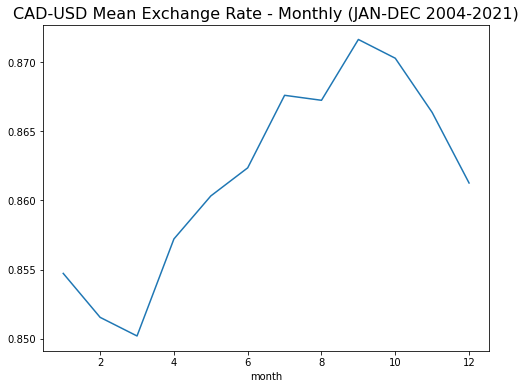

In [27]:
## Mean Value CAD-USD, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
us_monthly_analytics['y']['mean'].plot()
plt.title('CAD-USD Mean Exchange Rate - Monthly (JAN-DEC 2004-2021)', fontsize=16);

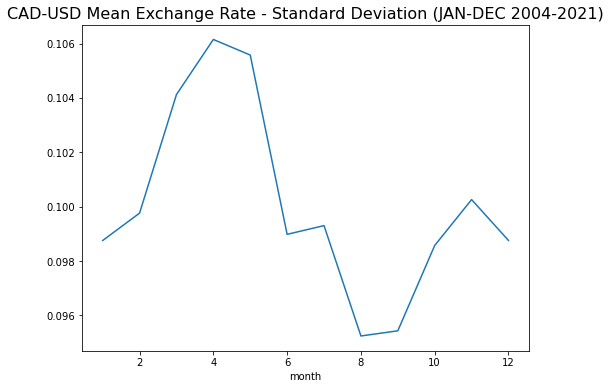

In [28]:
## Standard Deviation CAD-USD, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
us_monthly_analytics['y']['std'].plot()
plt.title('CAD-USD Mean Exchange Rate - Standard Deviation (JAN-DEC 2004-2021)', fontsize=16);

In [29]:
## check correlation
df_us_monthly[['y', 'nifty', 'inflation_cad_usd', 'nifty_prev_month',
       'price_rollingmean_lastquarter','month']].corr()

y     nifty  inflation_cad_usd  \
y                              1.000000 -0.406442          -0.252898   
nifty                         -0.406442  1.000000           0.245096   
inflation_cad_usd             -0.252898  0.245096           1.000000   
nifty_prev_month               0.985178 -0.415604          -0.218883   
price_rollingmean_lastquarter  0.989569 -0.429762          -0.229439   
month                          0.055300  0.025341           0.099591   

                               nifty_prev_month  \
y                                      0.985178   
nifty                                 -0.415604   
inflation_cad_usd                     -0.218883   
nifty_prev_month                       1.000000   
price_rollingmean_lastquarter          0.997782   
month                                  0.057501   

                               price_rollingmean_lastquarter     month  
y                                                   0.989569  0.055300  
nifty                                              -0.429762  0.025341  
inflation_cad_usd                                  -0.229439  0.099591  
nifty_prev_month                                    0.997782  0.057501  
price_rollingmean_lastquarter                       1.000000  0.046844  
month                                               0.046844  1.000000

In [30]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [31]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_us_monthly['high_rate'] = df_us_monthly['y'].apply(over_80)

## Split each month into smaller bin size
df_us_monthly['month_bins'] = pd.cut(df_us_monthly['month'], bins=3, labels=False)

## train_test
train_usd_monthly = df_us_monthly[df_us_monthly['ds'] < '2021-05-01'][2:] ##removing NaN's
test_usd_monthly = df_us_monthly[df_us_monthly['ds'] >= '2021-05-01']

## Modelling
model_usd_monthly = Prophet(interval_width=0.90, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_usd_monthly.add_regressor('nifty', standardize=True) ## additive by default
model_usd_monthly.add_regressor('inflation_cad_usd', standardize=True, mode='multiplicative')
model_usd_monthly.add_regressor('nifty_prev_month', standardize=False, mode='multiplicative')
model_usd_monthly.add_regressor('price_rollingmean_lastquarter', standardize=False, mode='multiplicative')
model_usd_monthly.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_usd_monthly.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_usd_monthly.fit(train_usd_monthly)

## check params using model_name.params here

## same as test size (train=209, test=5)
future_usd_monthly = model_usd_monthly.make_future_dataframe(periods=5, freq='M')

## Exogenous Variables for test dataset
future_usd_monthly['nifty'] = df_us_monthly['nifty']
future_usd_monthly['inflation_cad_usd'] = df_us_monthly['inflation_cad_usd']
future_usd_monthly['nifty_prev_month'] = df_us_monthly['nifty_prev_month']
future_usd_monthly['price_rollingmean_lastquarter'] = df_us_monthly['price_rollingmean_lastquarter']
future_usd_monthly['high_rate'] = df_us_monthly['high_rate']
future_usd_monthly['month_bins'] = df_us_monthly['month_bins']

## Get Forecast
forecast_usd_monthly = model_usd_monthly.predict(future_usd_monthly[2:])
forecast_usd_monthly[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
204 2021-05-31  0.831795    0.815254    0.849615
205 2021-06-30  0.826364    0.808735    0.843470
206 2021-07-31  0.836083    0.818804    0.853593
207 2021-08-31  0.846031    0.827889    0.864589
208 2021-09-30  0.889980    0.872406    0.908187

Figure(720x432)
Figure(648x1296)


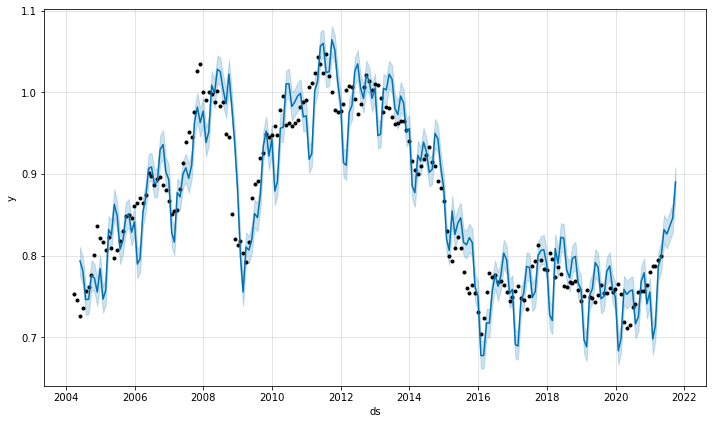

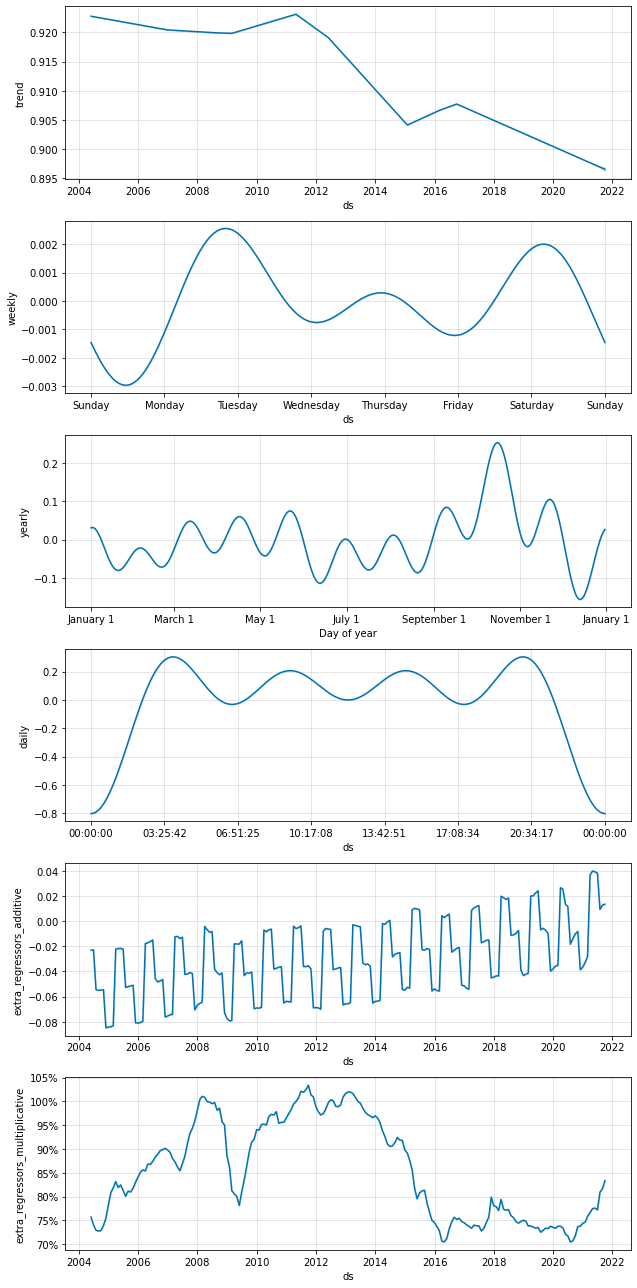

In [32]:
usd_monthly_plot = model_usd_monthly.plot(forecast_usd_monthly)
print(usd_monthly_plot);
print(model_usd_monthly.plot_components(forecast_usd_monthly));

In [33]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_usd_monthly = cross_validation(model=model_usd_monthly, initial = '4298 days', horizon = '30 days') 
# usd_monthly_performance = performance_metrics(cv_results_usd_monthly)
# usd_monthly_performance

INFO:fbprophet:Making 124 forecasts with cutoffs between 2016-01-12 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/124 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  coverage
0   4 days  0.000477  0.021848  0.015349  0.020412  0.013722  0.750000
1   5 days  0.000470  0.021677  0.015743  0.020815  0.015292  0.812500
2   6 days  0.000408  0.020192  0.014606  0.019258  0.017491  0.777778
3   7 days  0.000160  0.012650  0.010141  0.013326  0.011761  0.888889
4   8 days  0.000059  0.007696  0.006271  0.008237  0.005371  0.916667
5   9 days  0.000061  0.007830  0.006137  0.008146  0.005512  1.000000
6  10 days  0.000160  0.012654  0.010814  0.014560  0.014062  0.833333
7  11 days  0.000213  0.014579  0.013157  0.017668  0.020928  0.666667
8  12 days  0.000218  0.014762  0.013563  0.018014  0.019784  0.666667
9  13 days  0.000156  0.012470  0.010783  0.013998  0.013732  0.805556
10 14 days  0.000113  0.010620  0.008874  0.011341  0.012042  0.916667
11 15 days  0.000103  0.010156  0.008393  0.010747  0.013766  0.916667
12 16 days  0.000107  0.010353  0.008411  0.010825  0.009585  0.916667
13 17 days  0.000091  0.009527  0.007445  0.009599  0.009585  0.930556
14 18 days  0.000113  0.010625  0.008075  0.010662  0.008390  0.902778
15 19 days  0.000477  0.021848  0.015349  0.020412  0.013722  0.750000
16 20 days  0.000470  0.021677  0.015743  0.020815  0.013441  0.812500
17 21 days  0.000408  0.020192  0.014606  0.019258  0.013441  0.861111
18 22 days  0.000160  0.012650  0.010141  0.013326  0.011761  0.972222
19 23 days  0.000059  0.007696  0.006271  0.008237  0.005371  1.000000
20 24 days  0.000061  0.007830  0.006137  0.008146  0.005512  1.000000
21 25 days  0.000160  0.012654  0.010814  0.014560  0.014062  0.916667
22 26 days  0.000213  0.014579  0.013157  0.017668  0.020928  0.750000
23 27 days  0.000218  0.014762  0.013563  0.018014  0.019784  0.750000
24 28 days  0.000156  0.012470  0.010783  0.013998  0.013732  0.819444
25 29 days  0.000115  0.010708  0.008949  0.011436  0.012042  0.916667
26 30 days  0.000118  0.010848  0.008857  0.011400  0.009585  0.916667

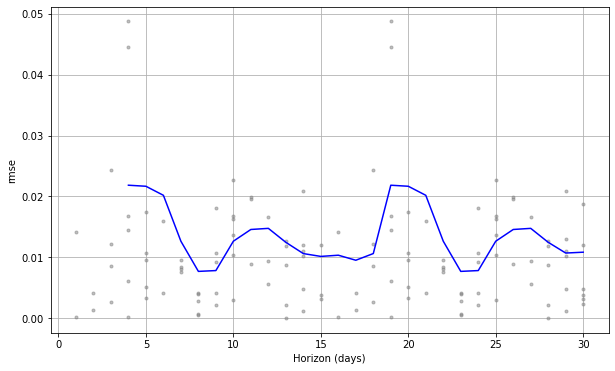

In [34]:
residualplot_usd_monthly_testdays = plot_cross_validation_metric(cv_results_usd_monthly, metric='rmse')

<AxesSubplot:ylabel='Density'>

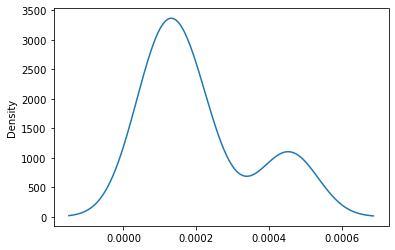

In [35]:
usd_monthly_performance['mse'].plot(kind='kde') ## Residuals are bimodal

In [126]:
test_usd_monthly['y'].reset_index(drop=True)

0    0.824319
1    0.832306
2    0.842759
3    0.845030
4    0.847744
Name: y, dtype: float64

In [36]:
multivariate_usd_monthly_test = pd.DataFrame(forecast_usd_monthly.ds[-5:].reset_index(drop=True))
multivariate_usd_monthly_test['Actual'] = test_usd_monthly['y'].reset_index(drop=True)
multivariate_usd_monthly_test['Predicted'] = forecast_usd_monthly[-5:]['yhat'].reset_index(drop=True)

In [37]:
multivariate_usd_monthly_test

ds    Actual  Predicted
0 2021-05-31  0.824319   0.831795
1 2021-06-30  0.832306   0.826364
2 2021-07-31  0.842759   0.836083
3 2021-08-31  0.845030   0.846031
4 2021-09-30  0.847744   0.889980

In [118]:
## Export pickle file for this model
pickle.dump(model_usd_monthly,open('../Saved_Models_Pickle/model_usd_monthly.pkl','wb'))

### Monthly INR Forecast

In [38]:
df_inr_monthly = df_monthly[['inr_close','scaled_sensex_close','diff_norm_ind_cad_inflation','inr_close_prev','indclose_rolling_quarter']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_inr_monthly.reset_index(inplace=True)

## rename columns
df_inr_monthly.columns = ['ds','y','sensex', 'inflation_cad_inr', 'sensex_prev_month', 'price_rollingmean_lastquarter']
                 
## Feature engineer - month column (based on max prices)
df_inr_monthly['month'] = df_inr_monthly['ds'].dt.month             

In [39]:
## Base Graph

fig_base_inr = px.line(df_inr_monthly[:-3], x='ds', y='y', hover_data=['sensex', 'inflation_cad_inr', 'sensex_prev_month', 'price_rollingmean_lastquarter', 'month'], title = ' Monthly Exchange Rates: CAD->INR Ex. 1 CAD = 58 INR',
                       labels={ "ds": "Time Period (Years 2004 - Present)","y": "Exchange Rate" })

fig_base_inr.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_inr.show()

In [40]:
inr_monthly_analytics = df_inr_monthly[['month','y']].groupby('month').agg({'y':{'mean','std'}})

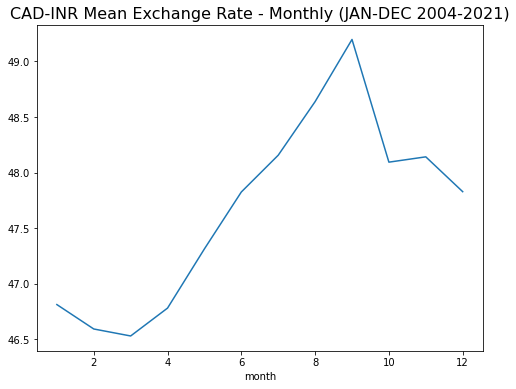

In [41]:
## Mean Value CAD-INR, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
inr_monthly_analytics['y']['mean'].plot()
plt.title('CAD-INR Mean Exchange Rate - Monthly (JAN-DEC 2004-2021)', fontsize=16);

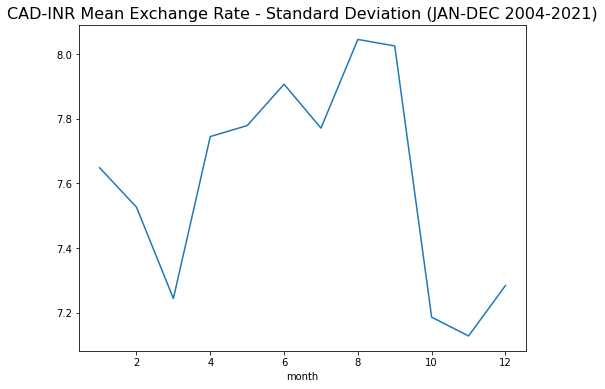

In [42]:
## Standard Deviation CAD-INR, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
inr_monthly_analytics['y']['std'].plot()
plt.title('CAD-INR Mean Exchange Rate - Standard Deviation (JAN-DEC 2004-2021)', fontsize=16);

In [43]:
## check correlation
df_inr_monthly[['y','sensex', 'inflation_cad_inr', 'sensex_prev_month', 'price_rollingmean_lastquarter','month']].corr()

y    sensex  inflation_cad_inr  \
y                              1.000000  0.794695          -0.693825   
sensex                         0.794695  1.000000          -0.637553   
inflation_cad_inr             -0.693825 -0.637553           1.000000   
sensex_prev_month              0.991658  0.791939          -0.699336   
price_rollingmean_lastquarter  0.994431  0.792815          -0.706462   
month                          0.085722  0.026801          -0.015745   

                               sensex_prev_month  \
y                                       0.991658   
sensex                                  0.791939   
inflation_cad_inr                      -0.699336   
sensex_prev_month                       1.000000   
price_rollingmean_lastquarter           0.998566   
month                                   0.070873   

                               price_rollingmean_lastquarter     month  
y                                                   0.994431  0.085722  
sensex                                              0.792815  0.026801  
inflation_cad_inr                                  -0.706462 -0.015745  
sensex_prev_month                                   0.998566  0.070873  
price_rollingmean_lastquarter                       1.000000  0.055418  
month                                               0.055418  1.000000

In [44]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [45]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_inr_monthly['high_rate'] = df_inr_monthly['y'].apply(over_80)

## Split each month into smaller bin size
df_inr_monthly['month_bins'] = pd.cut(df_inr_monthly['month'], bins=3, labels=False)

## train_test
train_inr_monthly = df_inr_monthly[df_inr_monthly['ds'] < '2021-05-01'][2:] ##removing NaN's
test_inr_monthly = df_inr_monthly[df_inr_monthly['ds'] >= '2021-05-01']

## Modelling
model_inr_monthly = Prophet(interval_width=0.90, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_inr_monthly.add_regressor('sensex', standardize=True) ## additive by default
model_inr_monthly.add_regressor('inflation_cad_inr', standardize=True, mode='multiplicative')
model_inr_monthly.add_regressor('sensex_prev_month', standardize=False, mode='multiplicative')
model_inr_monthly.add_regressor('price_rollingmean_lastquarter', standardize=False, mode='multiplicative')
model_inr_monthly.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_inr_monthly.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_inr_monthly.fit(train_inr_monthly)

## check params using model_name.params here

## same as test size (train=209, test=5)
future_inr_monthly = model_inr_monthly.make_future_dataframe(periods=5, freq='M')

## Exogenous Variables for test dataset
future_inr_monthly['sensex'] = df_inr_monthly['sensex']
future_inr_monthly['inflation_cad_inr'] = df_inr_monthly['inflation_cad_inr']
future_inr_monthly['sensex_prev_month'] = df_inr_monthly['sensex_prev_month']
future_inr_monthly['price_rollingmean_lastquarter'] = df_inr_monthly['price_rollingmean_lastquarter']
future_inr_monthly['high_rate'] = df_inr_monthly['high_rate']
future_inr_monthly['month_bins'] = df_inr_monthly['month_bins']

## Get Forecast
forecast_inr_monthly = model_inr_monthly.predict(future_inr_monthly[2:])
forecast_inr_monthly[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
204 2021-05-31  62.300811   61.206191   63.312904
205 2021-06-30  63.215026   62.206632   64.270971
206 2021-07-31  60.086802   59.049431   61.190161
207 2021-08-31  61.120549   60.095321   62.068765
208 2021-09-30  65.674962   64.658668   66.740904

Figure(720x432)
Figure(648x1296)


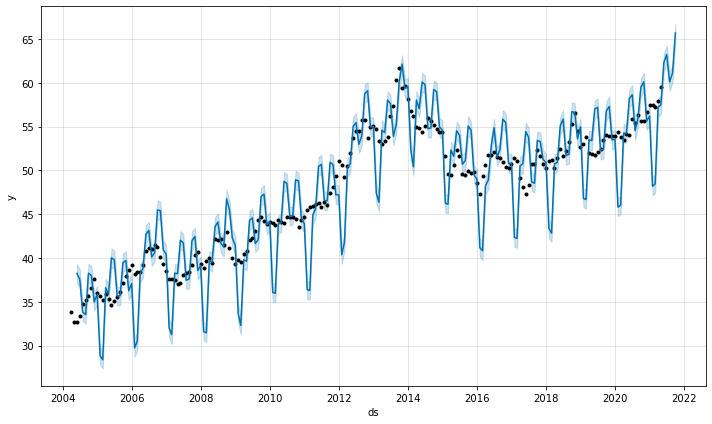

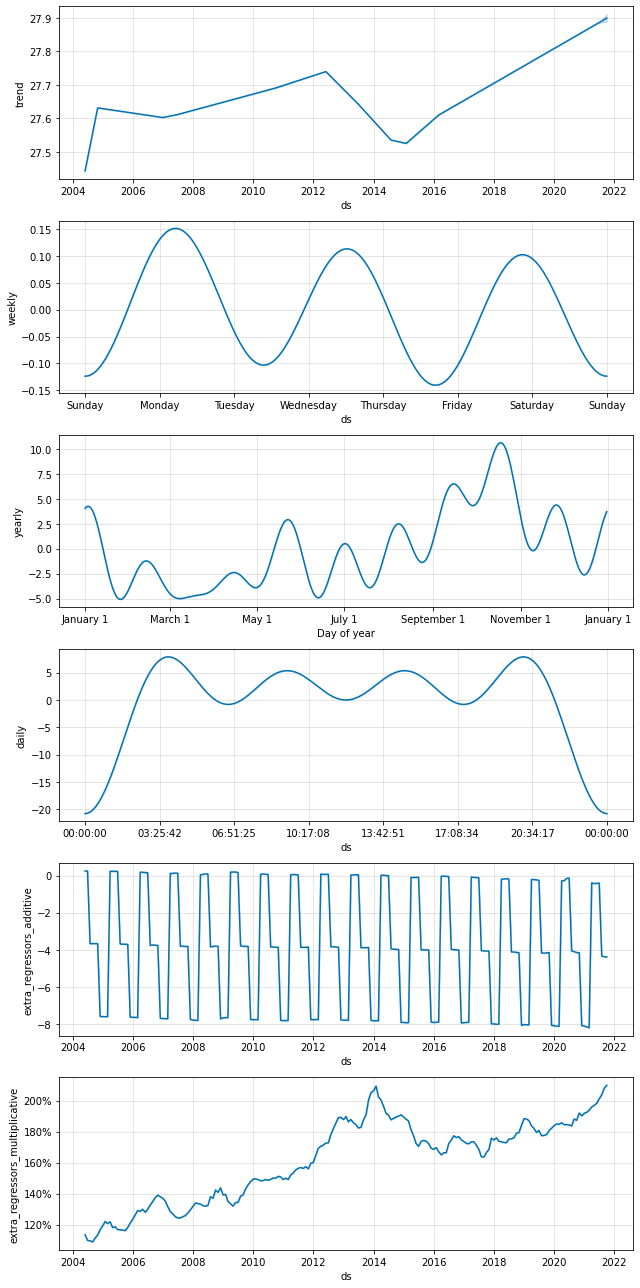

In [46]:
inr_monthly_plot = model_inr_monthly.plot(forecast_inr_monthly)
print(inr_monthly_plot);
print(model_inr_monthly.plot_components(forecast_inr_monthly));

In [47]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_inr_monthly = cross_validation(model=model_inr_monthly, initial = '4298 days', horizon = '30 days') 
# inr_monthly_performance = performance_metrics(cv_results_inr_monthly)
# inr_monthly_performance


INFO:fbprophet:Making 124 forecasts with cutoffs between 2016-01-12 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/124 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  coverage
0   4 days  1.933981  1.390677  1.180206  0.022496  0.020977  0.416667
1   5 days  1.645628  1.282820  0.985142  0.018996  0.013671  0.625000
2   6 days  1.352577  1.163004  0.838235  0.016201  0.012372  0.722222
3   7 days  0.552639  0.743397  0.567545  0.010962  0.010069  0.861111
4   8 days  0.269588  0.519219  0.423098  0.008186  0.006325  0.916667
5   9 days  0.444013  0.666343  0.501536  0.009964  0.006722  0.791667
6  10 days  0.667496  0.817004  0.661830  0.013094  0.011599  0.750000
7  11 days  0.725149  0.851557  0.665766  0.013100  0.016954  0.733333
8  12 days  0.652970  0.808066  0.623865  0.012162  0.010973  0.750000
9  13 days  0.613215  0.783081  0.633362  0.012169  0.012609  0.819444
10 14 days  0.420630  0.648560  0.597025  0.011238  0.011113  0.972222
11 15 days  0.372063  0.609970  0.566945  0.010675  0.011067  1.000000
12 16 days  0.365970  0.604955  0.563956  0.010527  0.011067  1.000000
13 17 days  0.464364  0.681442  0.625166  0.011607  0.011619  0.916667
14 18 days  0.697005  0.834868  0.785557  0.014637  0.015011  0.750000
15 19 days  1.933981  1.390677  1.180206  0.022496  0.020977  0.416667
16 20 days  1.645628  1.282820  0.985142  0.018996  0.013052  0.625000
17 21 days  1.352577  1.163004  0.838235  0.016201  0.010069  0.722222
18 22 days  0.552639  0.743397  0.567545  0.010962  0.010069  0.861111
19 23 days  0.269588  0.519219  0.423098  0.008186  0.006325  0.916667
20 24 days  0.444013  0.666343  0.501536  0.009964  0.005497  0.791667
21 25 days  0.667496  0.817004  0.661830  0.013094  0.014261  0.750000
22 26 days  0.725149  0.851557  0.665766  0.013100  0.016954  0.733333
23 27 days  0.652970  0.808066  0.623865  0.012162  0.010973  0.750000
24 28 days  0.613215  0.783081  0.633362  0.012169  0.012609  0.819444
25 29 days  0.429271  0.655188  0.608446  0.011438  0.011113  0.972222
26 30 days  0.473792  0.688325  0.631191  0.011591  0.011067  0.916667

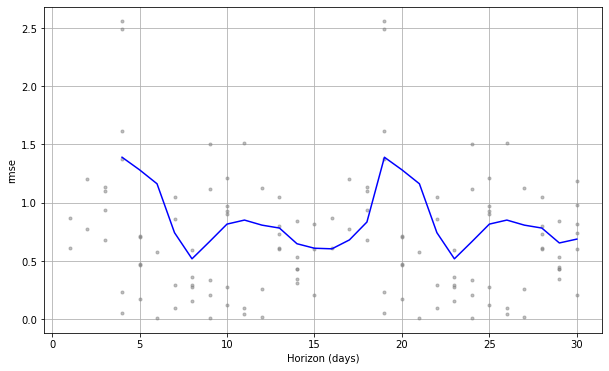

In [48]:
residualplot_inr_monthly_testdays = plot_cross_validation_metric(cv_results_inr_monthly, metric='rmse')

<AxesSubplot:ylabel='Density'>

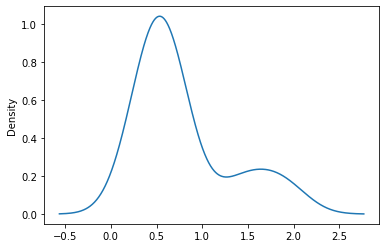

In [49]:
inr_monthly_performance['mse'].plot(kind='kde') ## Residuals are bimodal

In [50]:
multivariate_inr_monthly_test = pd.DataFrame(forecast_inr_monthly.ds[-5:].reset_index(drop=True))
multivariate_inr_monthly_test['Actual'] = test_inr_monthly['y'].reset_index(drop=True)
multivariate_inr_monthly_test['Predicted'] = forecast_inr_monthly[-5:]['yhat_lower'].reset_index(drop=True)

In [51]:
multivariate_inr_monthly_test

ds     Actual  Predicted
0 2021-05-31  60.387474  61.206191
1 2021-06-30  61.136905  62.206632
2 2021-07-31  61.210932  59.049431
3 2021-08-31  61.385103  60.095321
4 2021-09-30  62.101774  64.658668

In [119]:
## Export pickle file for this model
pickle.dump(model_inr_monthly,open('../Saved_Models_Pickle/model_inr_monthly.pkl','wb'))

### Monthly GBP Forecast

In [52]:
df_monthly.columns

Index(['inr_close', 'usd_close', 'gbp_close', 'scaled_sensex_close',
       'scaled_nifty_close', 'scaled_lse_close', 'scaled_india_close',
       'norm_canada_gdp', 'diff_norm_ind_cad_inflation',
       'diff_norm_usd_cad_inflation', 'diff_norm_gbp_cad_inflation',
       'inr_close_prev', 'usd_close_prev', 'gbp_close_prev',
       'indclose_rolling_quarter', 'usdclose_rolling_quarter',
       'gbpclose_rolling_quarter', 'inrclose_rolling_18months',
       'usdclose_rolling_18months', 'gbpclose_rolling_18months'],
      dtype='object')

In [53]:
df_gbp_monthly = df_monthly[['gbp_close','scaled_lse_close','diff_norm_gbp_cad_inflation','inr_close_prev','gbpclose_rolling_quarter']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_gbp_monthly.reset_index(inplace=True)

## rename columns
df_gbp_monthly.columns = ['ds','y','LSE', 'inflation_cad_gbp', 'lse_prev_month', 'price_rollingmean_lastquarter']
                 
## Feature engineer - month column (based on max prices)
df_gbp_monthly['month'] = df_gbp_monthly['ds'].dt.month             

In [54]:
## Base Graph

fig_base_gbp = px.line(df_gbp_monthly[:-3], x='ds', y='y', hover_data=['LSE', 'inflation_cad_gbp', 'lse_prev_month', 'price_rollingmean_lastquarter', 'month'], title = ' Monthly Exchange Rates: CAD->GBP Ex. 1 CAD = 0.59 GBP',
                       labels={ "ds": "Time Period (Years 2004 - Present)","y": "Exchange Rate" })

fig_base_gbp.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_gbp.show()

In [55]:
gbp_monthly_analytics = df_gbp_monthly[['month','y']].groupby('month').agg({'y':{'mean','std'}})

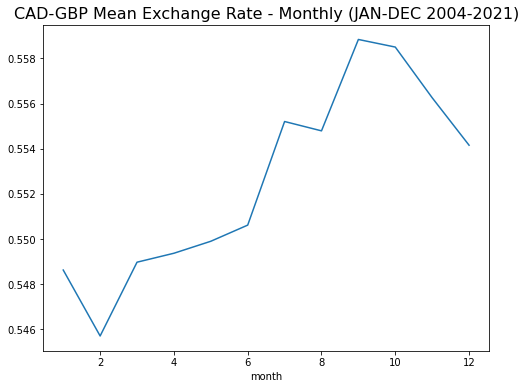

In [56]:
## Mean Value CAD-GBP, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
gbp_monthly_analytics['y']['mean'].plot()
plt.title('CAD-GBP Mean Exchange Rate - Monthly (JAN-DEC 2004-2021)', fontsize=16);

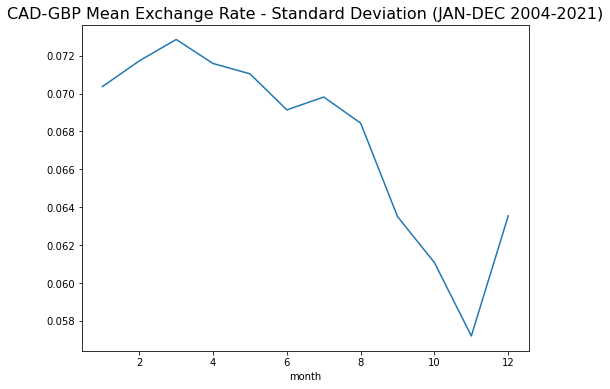

In [57]:
## Standard Deviation CAD-GBP, Monthly Plot (JAN-DEC 2004-2021)
plt.figure(figsize=(8,6))
gbp_monthly_analytics['y']['std'].plot()
plt.title('CAD-GBP Mean Exchange Rate - Standard Deviation (JAN-DEC 2004-2021)', fontsize=16);

In [58]:
## check correlation
df_gbp_monthly[['y','LSE', 'inflation_cad_gbp', 'lse_prev_month', 'price_rollingmean_lastquarter','month']].corr()

y       LSE  inflation_cad_gbp  \
y                              1.000000  0.271862          -0.496449   
LSE                            0.271862  1.000000          -0.582514   
inflation_cad_gbp             -0.496449 -0.582514           1.000000   
lse_prev_month                 0.679325  0.629210          -0.719950   
price_rollingmean_lastquarter  0.990796  0.270552          -0.511858   
month                          0.052967  0.012262          -0.017222   

                               lse_prev_month  price_rollingmean_lastquarter  \
y                                    0.679325                       0.990796   
LSE                                  0.629210                       0.270552   
inflation_cad_gbp                   -0.719950                      -0.511858   
lse_prev_month                       1.000000                       0.698670   
price_rollingmean_lastquarter        0.698670                       1.000000   
month                                0.070873                       0.028148   

                                  month  
y                              0.052967  
LSE                            0.012262  
inflation_cad_gbp             -0.017222  
lse_prev_month                 0.070873  
price_rollingmean_lastquarter  0.028148  
month                          1.000000

In [59]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [63]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_gbp_monthly['high_rate'] = df_gbp_monthly['y'].apply(over_80)

## Split each month into smaller bin size
df_gbp_monthly['month_bins'] = pd.cut(df_gbp_monthly['month'], bins=3, labels=False)

## train_test
train_gbp_monthly = df_gbp_monthly[df_gbp_monthly['ds'] < '2021-05-01'][2:] ##removing NaN's
test_gbp_monthly = df_gbp_monthly[df_gbp_monthly['ds'] >= '2021-05-01']

## Modelling
model_gbp_monthly = Prophet(interval_width=0.90, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_gbp_monthly.add_regressor('LSE', standardize=True) ## additive by default
model_gbp_monthly.add_regressor('inflation_cad_gbp', standardize=True, mode='multiplicative')
model_gbp_monthly.add_regressor('lse_prev_month', standardize=False, mode='multiplicative')
model_gbp_monthly.add_regressor('price_rollingmean_lastquarter', standardize=False, mode='multiplicative')
model_gbp_monthly.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_gbp_monthly.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_gbp_monthly.fit(train_gbp_monthly)

## check params using model_name.params here

## same as test size (train=209, test=5)
future_gbp_monthly = model_gbp_monthly.make_future_dataframe(periods=5, freq='M')

## Exogenous Variables for test dataset
future_gbp_monthly['LSE'] = df_gbp_monthly['LSE']
future_gbp_monthly['inflation_cad_gbp'] = df_gbp_monthly['inflation_cad_gbp']
future_gbp_monthly['lse_prev_month'] = df_gbp_monthly['lse_prev_month']
future_gbp_monthly['price_rollingmean_lastquarter'] = df_gbp_monthly['price_rollingmean_lastquarter']
future_gbp_monthly['high_rate'] = df_gbp_monthly['high_rate']
future_gbp_monthly['month_bins'] = df_gbp_monthly['month_bins']

## Get Forecast
forecast_gbp_monthly = model_gbp_monthly.predict(future_gbp_monthly[2:])
forecast_gbp_monthly[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
204 2021-05-31  0.619549    0.606717    0.633345
205 2021-06-30  0.622865    0.610175    0.635088
206 2021-07-31  0.581618    0.567523    0.594668
207 2021-08-31  0.579076    0.565480    0.592297
208 2021-09-30  0.632330    0.618976    0.644795

Figure(720x432)
Figure(648x1296)


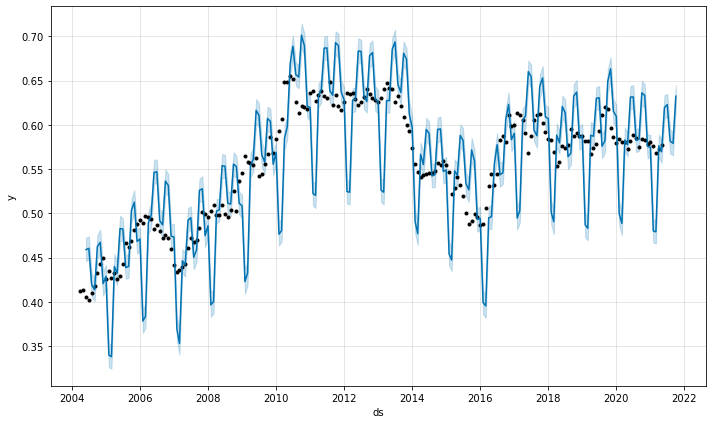

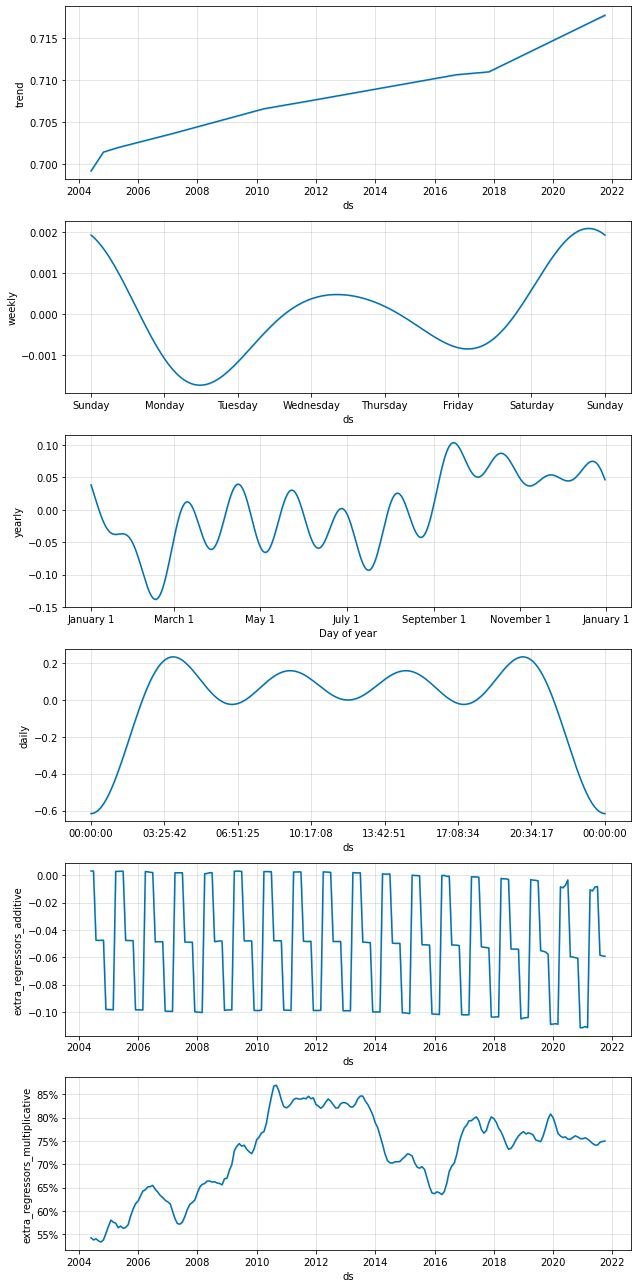

In [64]:
gbp_monthly_plot = model_gbp_monthly.plot(forecast_gbp_monthly)
print(gbp_monthly_plot);
print(model_gbp_monthly.plot_components(forecast_gbp_monthly));

In [65]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_gbp_monthly = cross_validation(model=model_gbp_monthly, initial = '4298 days', horizon = '30 days') 
# gbp_monthly_performance = performance_metrics(cv_results_gbp_monthly)
# gbp_monthly_performance

INFO:fbprophet:Making 124 forecasts with cutoffs between 2016-01-12 00:00:00 and 2021-03-31 00:00:00


  0%|          | 0/124 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  coverage
0   4 days  0.000163  0.012749  0.009244  0.016803  0.010974  0.750000
1   5 days  0.000140  0.011845  0.008790  0.016024  0.011458  0.833333
2   6 days  0.000220  0.014824  0.011545  0.020411  0.013053  0.694444
3   7 days  0.000200  0.014154  0.011235  0.019120  0.015667  0.638889
4   8 days  0.000253  0.015913  0.013744  0.022978  0.022830  0.500000
5   9 days  0.000195  0.013955  0.011798  0.019723  0.021020  0.583333
6  10 days  0.000152  0.012335  0.009749  0.016571  0.013658  0.716667
7  11 days  0.000160  0.012641  0.010539  0.017936  0.017108  0.650000
8  12 days  0.000121  0.011013  0.008961  0.015246  0.013120  0.750000
9  13 days  0.000103  0.010145  0.008899  0.015060  0.014514  0.819444
10 14 days  0.000067  0.008156  0.007062  0.012200  0.009880  0.916667
11 15 days  0.000089  0.009417  0.007653  0.013291  0.012264  0.833333
12 16 days  0.000080  0.008958  0.006947  0.012103  0.009120  0.833333
13 17 days  0.000106  0.010296  0.007664  0.013251  0.008637  0.763889
14 18 days  0.000092  0.009571  0.007013  0.012201  0.006512  0.819444
15 19 days  0.000163  0.012749  0.009244  0.016803  0.010974  0.750000
16 20 days  0.000140  0.011845  0.008790  0.016024  0.011458  0.833333
17 21 days  0.000220  0.014824  0.011545  0.020411  0.016490  0.694444
18 22 days  0.000200  0.014154  0.011235  0.019120  0.015667  0.638889
19 23 days  0.000253  0.015913  0.013744  0.022978  0.022830  0.500000
20 24 days  0.000195  0.013955  0.011798  0.019723  0.021020  0.500000
21 25 days  0.000152  0.012335  0.009749  0.016571  0.012049  0.633333
22 26 days  0.000160  0.012641  0.010539  0.017936  0.017108  0.600000
23 27 days  0.000121  0.011013  0.008961  0.015246  0.013120  0.750000
24 28 days  0.000103  0.010145  0.008899  0.015060  0.015621  0.819444
25 29 days  0.000066  0.008150  0.007050  0.012179  0.009880  0.916667
26 30 days  0.000093  0.009657  0.007970  0.013896  0.012366  0.833333

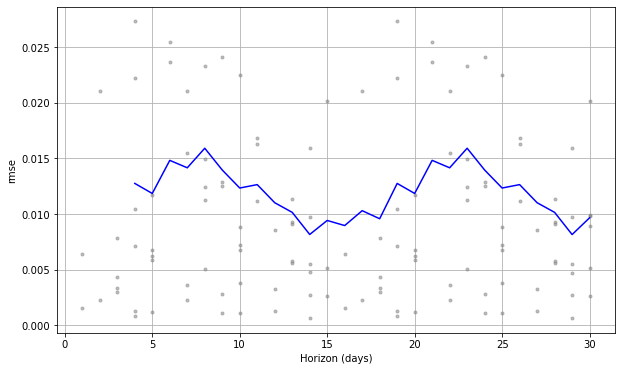

In [66]:
residualplot_gbp_monthly_testdays = plot_cross_validation_metric(cv_results_gbp_monthly, metric='rmse')

<AxesSubplot:ylabel='Density'>

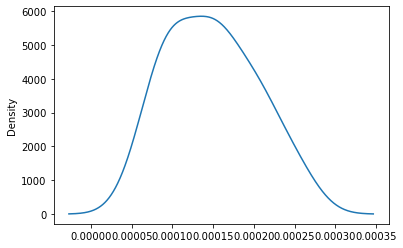

In [67]:
gbp_monthly_performance['mse'].plot(kind='kde') ## Residuals are bimodal

In [68]:
multivariate_gbp_monthly_test = pd.DataFrame(forecast_gbp_monthly.ds[-5:].reset_index(drop=True))
multivariate_gbp_monthly_test['Actual'] = test_gbp_monthly['y'].reset_index(drop=True)
multivariate_gbp_monthly_test['Predicted'] = forecast_gbp_monthly[-5:]['yhat_lower'].reset_index(drop=True)

In [69]:
multivariate_gbp_monthly_test

ds    Actual  Predicted
0 2021-05-31  0.585104   0.606717
1 2021-06-30  0.579059   0.610175
2 2021-07-31  0.581413   0.567523
3 2021-08-31  0.581734   0.565480
4 2021-09-30  0.579482   0.618976

In [120]:
## Export pickle file for this model
pickle.dump(model_gbp_monthly,open('../Saved_Models_Pickle/model_gbp_monthly.pkl','wb'))

 ## Daily Forecasts using fbprophet (USD - INR - GBP)

In [70]:
df_daily = daily_data.copy()

In [71]:
df_daily.columns

Index(['inr_open', 'inr_high', 'inr_low', 'inr_close', 'usd_open', 'usd_high',
       'usd_low', 'usd_close', 'gbp_open', 'gbp_high', 'gbp_low', 'gbp_close',
       'india_close_sensex', 'nifty_close', 'lse_close', 'tse_close',
       'indinflation', 'usinflation', 'uk_inflation', 'canada_inflation',
       'can_gdp'],
      dtype='object')

In [72]:
## Select required columns

df_daily = df_daily[['inr_close','usd_close','gbp_close',
            'india_close_sensex', 'nifty_close', 'lse_close', 'tse_close',
       'indinflation', 'usinflation', 'uk_inflation', 'canada_inflation',
       'can_gdp']]

In [73]:
## Feature Engineer - previous month highest closing price

sensexIndia = MinMaxScaler()
df_daily['scaled_sensex_close'] = sensexIndia.fit_transform(df_daily[['india_close_sensex']])
niftyUS = MinMaxScaler()
df_daily['scaled_nifty_close'] = niftyUS.fit_transform(df_daily[['nifty_close']])
lseUK = MinMaxScaler()
df_daily['scaled_lse_close'] = lseUK.fit_transform(df_daily[['lse_close']])
tseCanada = MinMaxScaler()
df_daily['scaled_india_close'] = tseCanada.fit_transform(df_daily[['tse_close']])

In [74]:
## Feature Engineer - Manually Normalize inflation, gdp and create a differenced column for inflation rates (can use MinMax/Standard scalar)

df_daily['norm_indinflation'] = (df_daily['indinflation']-df_daily['indinflation'].mean())/df_daily['indinflation'].std()
df_daily['norm_usinflation'] = (df_daily['usinflation']-df_daily['usinflation'].mean())/df_daily['usinflation'].std()
df_daily['norm_uk_inflation'] = (df_daily['uk_inflation']-df_daily['uk_inflation'].mean())/df_daily['uk_inflation'].std()
df_daily['norm_canada_inflation'] = (df_daily['canada_inflation']-df_daily['canada_inflation'].mean())/df_daily['canada_inflation'].std()

df_daily['norm_canada_gdp'] = (df_daily['can_gdp']-df_daily['can_gdp'].mean())/df_daily['can_gdp'].std()

df_daily['diff_norm_ind_cad_inflation'] = df_daily['norm_canada_inflation'] - df_daily['norm_indinflation']
df_daily['diff_norm_usd_cad_inflation'] = df_daily['norm_canada_inflation'] - df_daily['norm_usinflation'] 
df_daily['diff_norm_gbp_cad_inflation'] = df_daily['norm_canada_inflation'] - df_daily['norm_uk_inflation']

In [75]:
## Feature Engineer - Previous month prices and shift to predict next month
df_daily['inr_close_prev'] = df_daily['inr_close'].shift(1)
df_daily['usd_close_prev'] = df_daily['usd_close'].shift(1)
df_daily['gbp_close_prev'] = df_daily['gbp_close'].shift(1)

df_daily['scaled_nifty_close_prev'] = df_daily['scaled_nifty_close'].shift(1)
df_daily['scaled_sensex_close_prev'] = df_daily['scaled_sensex_close'].shift(1)
df_daily['scaled_lse_close_prev'] = df_daily['scaled_lse_close'].shift(1)

In [76]:
df_daily = df_daily.drop(['indinflation','usinflation','uk_inflation','canada_inflation','india_close_sensex','nifty_close','lse_close','tse_close','can_gdp','norm_indinflation','norm_usinflation','norm_uk_inflation','norm_canada_inflation','scaled_nifty_close', 'scaled_lse_close', 'scaled_india_close'], axis=1)

In [77]:
df_daily.columns

Index(['inr_close', 'usd_close', 'gbp_close', 'scaled_sensex_close',
       'norm_canada_gdp', 'diff_norm_ind_cad_inflation',
       'diff_norm_usd_cad_inflation', 'diff_norm_gbp_cad_inflation',
       'inr_close_prev', 'usd_close_prev', 'gbp_close_prev',
       'scaled_nifty_close_prev', 'scaled_sensex_close_prev',
       'scaled_lse_close_prev'],
      dtype='object')

### Daily USD Forecast

In [78]:
df_us_daily = df_daily[['usd_close','scaled_nifty_close_prev','diff_norm_usd_cad_inflation','usd_close_prev']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_us_daily.reset_index(inplace=True)

## rename columns
df_us_daily.columns = ['ds','y','nifty_prev', 'inflation_cad_usd', 'close_yesterday']
                 
## Feature engineer - month column (based on max prices)
df_us_daily['month'] = df_us_daily['ds'].dt.month           

In [79]:
## Base Graph

fig_base_us_daily = px.line(df_us_daily[:-84], x='ds', y='y', hover_data=['nifty_prev', 'inflation_cad_usd', 'close_yesterday', 'month'],
                            title = ' Daily Exchange Rates: CAD->USD Ex. 1 CAD = 0.80 USD',
                            labels={
                     "ds": "Time Period (Years 2004 - Present)",
                     "y": "Exchange Rate"
                 })

fig_base_us_daily.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_us_daily.show()

In [80]:
## check correlation
df_us_daily[['y','nifty_prev', 'inflation_cad_usd', 'close_yesterday', 'month']].corr()

y  nifty_prev  inflation_cad_usd  close_yesterday  \
y                  1.000000   -0.403232          -0.117493         0.998738   
nifty_prev        -0.403232    1.000000           0.142473        -0.402992   
inflation_cad_usd -0.117493    0.142473           1.000000        -0.116605   
close_yesterday    0.998738   -0.402992          -0.116605         1.000000   
month              0.054387    0.023279           0.073597         0.054358   

                      month  
y                  0.054387  
nifty_prev         0.023279  
inflation_cad_usd  0.073597  
close_yesterday    0.054358  
month              1.000000

In [81]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [82]:
df_us_daily.isnull().sum()

ds                   0
y                    0
nifty_prev           1
inflation_cad_usd    0
close_yesterday      1
month                0
dtype: int64

In [83]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_us_daily['high_rate'] = df_us_daily['y'].apply(over_80)

## Split each month into smaller bin size
df_us_daily['month_bins'] = pd.cut(df_us_daily['month'], bins=3, labels=False)

## train_test
train_usd_daily = df_us_daily[df_us_daily['ds'] < '2021-05-01'][1:] ##removing NaN's
test_usd_daily = df_us_daily[df_us_daily['ds'] >= '2021-05-01']

## Modelling
model_usd_daily = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_usd_daily.add_regressor('nifty_prev', standardize=True) ## additive by default
model_usd_daily.add_regressor('inflation_cad_usd', standardize=True, mode='multiplicative')
model_usd_daily.add_regressor('close_yesterday', standardize=False, mode='multiplicative')
model_usd_daily.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_usd_daily.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_usd_daily.fit(train_usd_daily)

## check params using model_name.params here

## same as test size (train=4598, test=106)
future_usd_daily = model_usd_daily.make_future_dataframe(periods=109, freq='B')

## Exogenous Variables for test dataset
future_usd_daily['nifty_prev'] = df_us_daily['nifty_prev']
future_usd_daily['inflation_cad_usd'] = df_us_daily['inflation_cad_usd']
future_usd_daily['close_yesterday'] = df_us_daily['close_yesterday']
future_usd_daily['high_rate'] = df_us_daily['high_rate']
future_usd_daily['month_bins'] = df_us_daily['month_bins']

## Get Forecast
forecast_usd_daily = model_usd_daily.predict(future_usd_daily[1:])
forecast_usd_daily[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
4624 2021-09-24  0.850029    0.840060    0.859635
4625 2021-09-27  0.849702    0.839845    0.859340
4626 2021-09-28  0.850249    0.840136    0.859694
4627 2021-09-29  0.850328    0.839923    0.859551
4628 2021-09-30  0.850791    0.841770    0.860482

Figure(720x432)
Figure(648x1296)


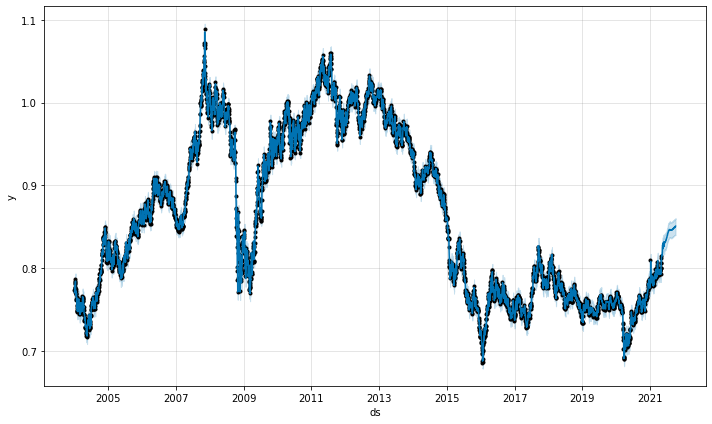

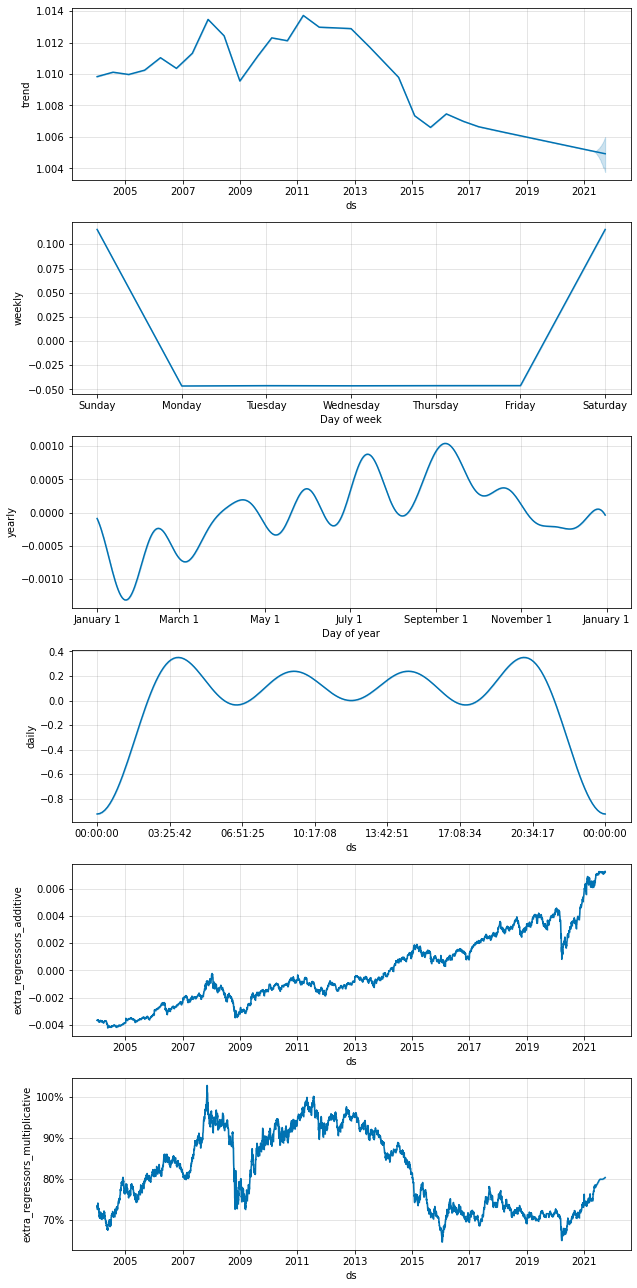

In [84]:
usd_daily_plot = model_usd_daily.plot(forecast_usd_daily)
print(usd_daily_plot);
print(model_usd_daily.plot_components(forecast_usd_daily));

In [85]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_usd_daily = cross_validation(model=model_usd_daily, initial = '4298 days', horizon = '109 days') 
# usd_daily_performance = performance_metrics(cv_results_usd_daily)
# usd_daily_performance

INFO:fbprophet:Making 36 forecasts with cutoffs between 2015-10-22 12:00:00 and 2021-01-11 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  \
0    11 days 00:00:00  0.000013  0.003573  0.002616  0.003448  0.002545   
1    11 days 12:00:00  0.000013  0.003565  0.002608  0.003435  0.002566   
2    12 days 00:00:00  0.000012  0.003521  0.002567  0.003379  0.002507   
3    12 days 12:00:00  0.000013  0.003547  0.002603  0.003425  0.002596   
4    13 days 00:00:00  0.000013  0.003550  0.002616  0.003442  0.002627   
..                ...       ...       ...       ...       ...       ...   
192 107 days 00:00:00  0.000015  0.003925  0.002671  0.003496  0.002394   
193 107 days 12:00:00  0.000015  0.003928  0.002664  0.003486  0.002408   
194 108 days 00:00:00  0.000015  0.003921  0.002650  0.003467  0.002369   
195 108 days 12:00:00  0.000016  0.003951  0.002684  0.003511  0.002385   
196 109 days 00:00:00  0.000015  0.003919  0.002657  0.003477  0.002369   

     coverage  
0    0.978571  
1    0.978571  
2    0.978571  
3    0.978571  
4    0.978846  
..        ...  
192  0.985714  
193  0.985714  
194  0.985714  
195  0.985714  
196  0.985714  

[197 rows x 7 columns]

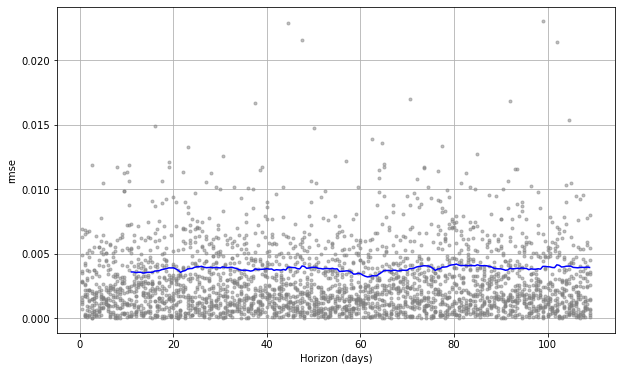

In [86]:
residualplot_usd_daily_testdays = plot_cross_validation_metric(cv_results_usd_daily, metric='rmse')

<AxesSubplot:ylabel='Density'>

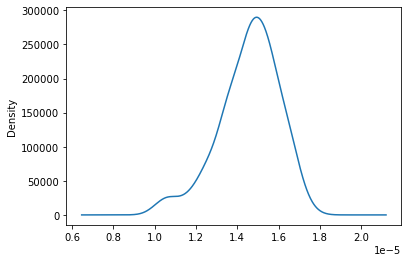

In [87]:
usd_daily_performance['mse'].plot(kind='kde') ## Residuals are bimodal

In [88]:
multivariate_usd_daily_test = pd.DataFrame(forecast_usd_daily.ds[-109:].reset_index(drop=True))
multivariate_usd_daily_test['Actual'] = test_usd_daily['y'].reset_index(drop=True)
multivariate_usd_daily_test['Predicted'] = forecast_usd_daily[-109:]['yhat'].reset_index(drop=True)

In [89]:
multivariate_usd_daily_test[20:]

ds    Actual  Predicted
20  2021-05-31  0.828372   0.826416
21  2021-06-01  0.828375   0.830696
22  2021-06-02  0.828452   0.830549
23  2021-06-03  0.828778   0.830757
24  2021-06-04  0.829040   0.830836
..         ...       ...        ...
104 2021-09-24  0.849003   0.850029
105 2021-09-27  0.849266   0.849702
106 2021-09-28  0.849556   0.850249
107 2021-09-29  0.849913   0.850328
108 2021-09-30  0.850330   0.850791

[89 rows x 3 columns]

In [127]:
multivariate_usd_daily_test.set_index('ds')

Actual  Predicted
ds                             
2021-05-03  0.814392   0.814701
2021-05-04  0.814326   0.816348
2021-05-05  0.812995   0.816003
2021-05-06  0.815189   0.815973
2021-05-07  0.822774   0.814825
...              ...        ...
2021-09-24  0.849003   0.850029
2021-09-27  0.849266   0.849702
2021-09-28  0.849556   0.850249
2021-09-29  0.849913   0.850328
2021-09-30  0.850330   0.850791

[109 rows x 2 columns]

In [121]:
## Export pickle file for this model
pickle.dump(model_usd_daily,open('../Saved_Models_Pickle/model_usd_daily.pkl','wb'))

### Daily INR Forecast

In [90]:
df_daily.columns

Index(['inr_close', 'usd_close', 'gbp_close', 'scaled_sensex_close',
       'norm_canada_gdp', 'diff_norm_ind_cad_inflation',
       'diff_norm_usd_cad_inflation', 'diff_norm_gbp_cad_inflation',
       'inr_close_prev', 'usd_close_prev', 'gbp_close_prev',
       'scaled_nifty_close_prev', 'scaled_sensex_close_prev',
       'scaled_lse_close_prev'],
      dtype='object')

In [91]:
df_inr_daily = df_daily[['inr_close','scaled_sensex_close_prev','diff_norm_ind_cad_inflation','inr_close_prev']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_inr_daily.reset_index(inplace=True)

## rename columns
df_inr_daily.columns = ['ds','y','sensex_prev', 'inflation_cad_inr', 'close_yesterday']
                 
## Feature engineer - month column (based on max prices)
df_inr_daily['month'] = df_inr_daily['ds'].dt.month           

In [92]:
## Base Graph

fig_base_inr_daily = px.line(df_inr_daily[:-84], x='ds', y='y', hover_data=['sensex_prev', 'inflation_cad_inr', 'close_yesterday', 'month'],
                            title = ' Daily Exchange Rates: CAD->INR Ex. 1 CAD = 58 INR',
                            labels={
                     "ds": "Time Period (Years 2004 - Present)",
                     "y": "Exchange Rate"
                 })

fig_base_inr_daily.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_inr_daily.show()

In [93]:
## check correlation
df_inr_daily[['y','sensex_prev', 'inflation_cad_inr', 'close_yesterday', 'month']].corr()

y  sensex_prev  inflation_cad_inr  close_yesterday  \
y                  1.000000     0.791694          -0.691857         0.999121   
sensex_prev        0.791694     1.000000          -0.636433         0.791725   
inflation_cad_inr -0.691857    -0.636433           1.000000        -0.692206   
close_yesterday    0.999121     0.791725          -0.692206         1.000000   
month              0.084487     0.024762          -0.014012         0.084007   

                      month  
y                  0.084487  
sensex_prev        0.024762  
inflation_cad_inr -0.014012  
close_yesterday    0.084007  
month              1.000000

In [94]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [95]:
df_inr_daily.isnull().sum()

ds                   0
y                    0
sensex_prev          1
inflation_cad_inr    0
close_yesterday      1
month                0
dtype: int64

In [96]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_inr_daily['high_rate'] = df_inr_daily['y'].apply(over_80)

## Split each month into smaller bin size
df_inr_daily['month_bins'] = pd.cut(df_inr_daily['month'], bins=3, labels=False)

## train_test
train_inr_daily = df_inr_daily[df_inr_daily['ds'] < '2021-05-01'][1:] ##removing NaN's
test_inr_daily = df_inr_daily[df_inr_daily['ds'] >= '2021-05-01']

## Modelling
model_inr_daily = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_inr_daily.add_regressor('sensex_prev', standardize=True) ## additive by default
model_inr_daily.add_regressor('inflation_cad_inr', standardize=True, mode='multiplicative')
model_inr_daily.add_regressor('close_yesterday', standardize=False, mode='multiplicative')
model_inr_daily.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_inr_daily.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_inr_daily.fit(train_inr_daily)

## check params using model_name.params here

## same as test size (train=4598, test=106)
future_inr_daily = model_inr_daily.make_future_dataframe(periods=109, freq='B')

## Exogenous Variables for test dataset
future_inr_daily['sensex_prev'] = df_inr_daily['sensex_prev']
future_inr_daily['inflation_cad_inr'] = df_inr_daily['inflation_cad_inr']
future_inr_daily['close_yesterday'] = df_inr_daily['close_yesterday']
future_inr_daily['high_rate'] = df_inr_daily['high_rate']
future_inr_daily['month_bins'] = df_inr_daily['month_bins']

## Get Forecast
forecast_inr_daily = model_inr_daily.predict(future_inr_daily[1:])
forecast_inr_daily[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
4624 2021-09-24  62.169580   61.519385   62.811780
4625 2021-09-27  62.203126   61.573656   62.823126
4626 2021-09-28  62.306535   61.667213   62.919541
4627 2021-09-29  62.295109   61.686139   62.890459
4628 2021-09-30  62.332013   61.728813   62.912706

Figure(720x432)
Figure(648x1296)


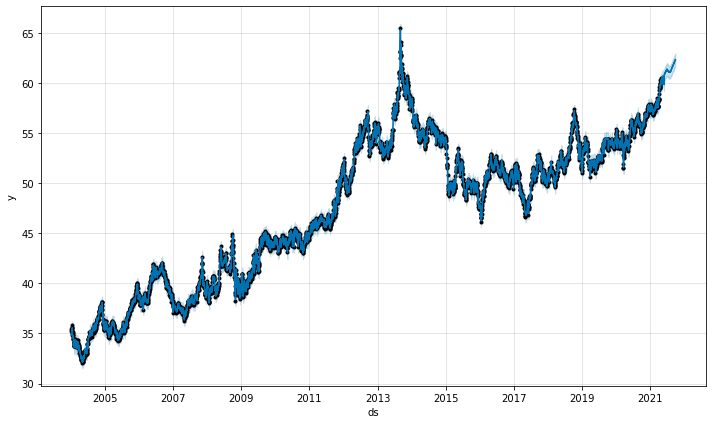

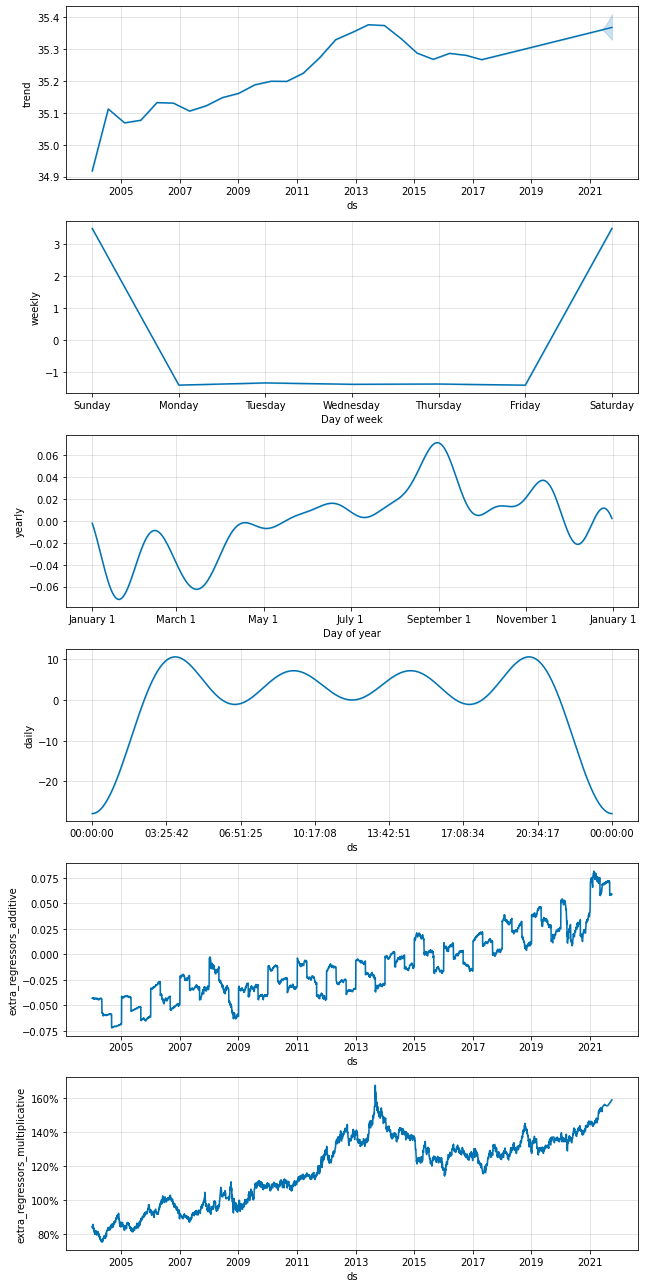

In [97]:
inr_daily_plot = model_inr_daily.plot(forecast_inr_daily)
print(inr_daily_plot);
print(model_inr_daily.plot_components(forecast_inr_daily));

In [145]:
forecast_inr_daily.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'close_yesterday', 'close_yesterday_lower', 'close_yesterday_upper',
       'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'high_rate', 'high_rate_lower',
       'high_rate_upper', 'inflation_cad_inr', 'inflation_cad_inr_lower',
       'inflation_cad_inr_upper', 'month_bins', 'month_bins_lower',
       'month_bins_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper',
       'sensex_prev', 'sensex_prev_lower', 'sensex_prev_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'yhat'],
      dtype='objec

In [ ]:
## Base Graph

fig_base_inr_daily = px.line(forecast_inr_daily, x='ds', y='y', hover_data=['sensex_prev', 'inflation_cad_inr', 'close_yesterday', 'month'],
                            title = ' Daily Exchange Rates: CAD->INR Ex. 1 CAD = 58 INR',
                            labels={
                     "ds": "Time Period (Years 2004 - Present)",
                     "y": "Exchange Rate"
                 })

fig_base_inr_daily.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_inr_daily.show()

In [98]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_inr_daily = cross_validation(model=model_inr_daily, initial = '4298 days', horizon = '109 days') 
# inr_daily_performance = performance_metrics(cv_results_inr_daily)
# inr_daily_performance

INFO:fbprophet:Making 36 forecasts with cutoffs between 2015-10-22 12:00:00 and 2021-01-11 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  \
0    11 days 00:00:00  0.083357  0.288716  0.217079  0.004175  0.003238   
1    11 days 12:00:00  0.080442  0.283624  0.213468  0.004105  0.003118   
2    12 days 00:00:00  0.077793  0.278914  0.210140  0.004044  0.003074   
3    12 days 12:00:00  0.071970  0.268272  0.204453  0.003937  0.003158   
4    13 days 00:00:00  0.072109  0.268531  0.204216  0.003931  0.003170   
..                ...       ...       ...       ...       ...       ...   
192 107 days 00:00:00  0.088396  0.297314  0.220633  0.004214  0.003084   
193 107 days 12:00:00  0.081696  0.285825  0.214349  0.004094  0.003063   
194 108 days 00:00:00  0.084281  0.290311  0.217229  0.004146  0.003124   
195 108 days 12:00:00  0.084029  0.289878  0.217798  0.004157  0.003167   
196 109 days 00:00:00  0.085398  0.292229  0.219345  0.004189  0.003167   

     coverage  
0    0.947253  
1    0.950510  
2    0.950595  
3    0.957143  
4    0.957143  
..        ...  
192  0.949725  
193  0.957143  
194  0.953571  
195  0.953571  
196  0.950000  

[197 rows x 7 columns]

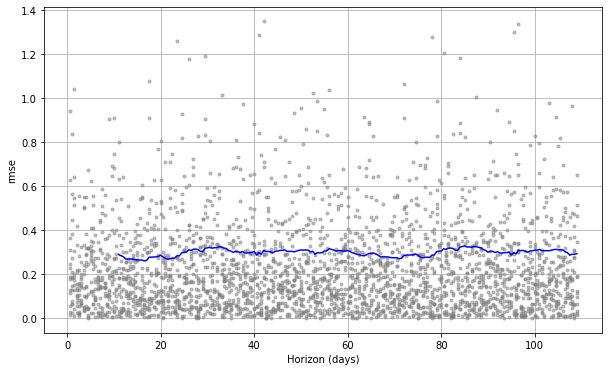

In [99]:
residualplot_inr_daily_testdays = plot_cross_validation_metric(cv_results_inr_daily, metric='rmse')

<AxesSubplot:ylabel='Density'>

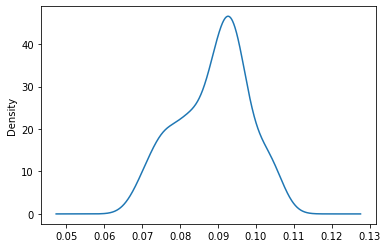

In [100]:
inr_daily_performance['mse'].plot(kind='kde') ## Residuals are normally distributed

In [101]:
multivariate_inr_daily_test = pd.DataFrame(forecast_inr_daily.ds[-109:].reset_index(drop=True))
multivariate_inr_daily_test['Actual'] = test_inr_daily['y'].reset_index(drop=True)
multivariate_inr_daily_test['Predicted'] = forecast_inr_daily[-109:]['yhat'].reset_index(drop=True)

In [102]:
multivariate_inr_daily_test[20:]

ds     Actual  Predicted
20  2021-05-31  60.811637  59.857881
21  2021-06-01  60.850608  60.184800
22  2021-06-02  60.877247  60.774774
23  2021-06-03  60.914742  60.822091
24  2021-06-04  60.951707  60.812584
..         ...        ...        ...
104 2021-09-24  62.337872  62.169580
105 2021-09-27  62.370022  62.203126
106 2021-09-28  62.398991  62.306535
107 2021-09-29  62.429804  62.295109
108 2021-09-30  62.460868  62.332013

[89 rows x 3 columns]

In [122]:
## Export pickle file for this model
pickle.dump(model_inr_daily,open('../Saved_Models_Pickle/model_inr_daily.pkl','wb'))

### Daily GBP Forecast

In [103]:
df_daily.columns

Index(['inr_close', 'usd_close', 'gbp_close', 'scaled_sensex_close',
       'norm_canada_gdp', 'diff_norm_ind_cad_inflation',
       'diff_norm_usd_cad_inflation', 'diff_norm_gbp_cad_inflation',
       'inr_close_prev', 'usd_close_prev', 'gbp_close_prev',
       'scaled_nifty_close_prev', 'scaled_sensex_close_prev',
       'scaled_lse_close_prev'],
      dtype='object')

In [104]:
df_gbp_daily = df_daily[['gbp_close','scaled_lse_close_prev','diff_norm_gbp_cad_inflation','gbp_close_prev']]

## select 'ds', 'y' and other exogenous variables for fbprophet
df_gbp_daily.reset_index(inplace=True)

## rename columns
df_gbp_daily.columns = ['ds','y','LSE_prev', 'inflation_cad_gbp', 'close_yesterday']
                 
## Feature engineer - month column (based on max prices)
df_gbp_daily['month'] = df_gbp_daily['ds'].dt.month           

In [105]:
## Base Graph

fig_base_gbp_daily = px.line(df_gbp_daily[:-84], x='ds', y='y', hover_data=['LSE_prev', 'inflation_cad_gbp', 'close_yesterday', 'month'],
                            title = ' Daily Exchange Rates: CAD->INR Ex. 1 CAD = 0.58 GBP',
                            labels={
                     "ds": "Time Period (Years 2004 - Present)",
                     "y": "Exchange Rate"
                 })

fig_base_gbp_daily.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="todate"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig_base_gbp_daily.show()

In [106]:
## check correlation
df_gbp_daily[['y','LSE_prev', 'inflation_cad_gbp', 'close_yesterday', 'month']].corr()

y  LSE_prev  inflation_cad_gbp  close_yesterday  \
y                  1.000000  0.269407          -0.495076         0.998761   
LSE_prev           0.269407  1.000000          -0.576934         0.269793   
inflation_cad_gbp -0.495076 -0.576934           1.000000        -0.495499   
close_yesterday    0.998761  0.269793          -0.495499         1.000000   
month              0.052374  0.012642          -0.015660         0.051390   

                      month  
y                  0.052374  
LSE_prev           0.012642  
inflation_cad_gbp -0.015660  
close_yesterday    0.051390  
month              1.000000

In [107]:
def over_80(rate):
    if rate > 0.80:
        return 1
    else:
        return 0

In [108]:
df_gbp_daily.isnull().sum()

ds                   0
y                    0
LSE_prev             1
inflation_cad_gbp    0
close_yesterday      1
month                0
dtype: int64

In [109]:
## Feature Engineer - Boolean Column (Flag, if the rate is too high)
df_gbp_daily['high_rate'] = df_gbp_daily['y'].apply(over_80)

## Split each month into smaller bin size
df_gbp_daily['month_bins'] = pd.cut(df_gbp_daily['month'], bins=3, labels=False)

## train_test
train_gbp_daily = df_gbp_daily[df_gbp_daily['ds'] < '2021-05-01'][1:] ##removing NaN's
test_gbp_daily = df_gbp_daily[df_gbp_daily['ds'] >= '2021-05-01']

## Modelling
model_gbp_daily = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True) ## 90% confidence interval

## add multivariate features, other than y and ds
model_gbp_daily.add_regressor('LSE_prev', standardize=True) ## additive by default
model_gbp_daily.add_regressor('inflation_cad_gbp', standardize=True, mode='multiplicative')
model_gbp_daily.add_regressor('close_yesterday', standardize=False, mode='multiplicative')
model_gbp_daily.add_regressor('high_rate', standardize=False, mode='multiplicative')
model_gbp_daily.add_regressor('month_bins', standardize=False)

## multiplicative to add interation between variables, 
## no point in standardizing month, we already standardized gdp and inflation columns

## Fit Model to train set
model_gbp_daily.fit(train_gbp_daily)

## check params using model_name.params here

## same as test size (train=4598, test=106)
future_gbp_daily = model_gbp_daily.make_future_dataframe(periods=109, freq='B')

## Exogenous Variables for test dataset
future_gbp_daily['LSE_prev'] = df_gbp_daily['LSE_prev']
future_gbp_daily['inflation_cad_gbp'] = df_gbp_daily['inflation_cad_gbp']
future_gbp_daily['close_yesterday'] = df_gbp_daily['close_yesterday']
future_gbp_daily['high_rate'] = df_gbp_daily['high_rate']
future_gbp_daily['month_bins'] = df_gbp_daily['month_bins']

## Get Forecast
forecast_gbp_daily = model_gbp_daily.predict(future_gbp_daily[1:])
forecast_gbp_daily[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
4624 2021-09-24  0.579787    0.573425    0.586442
4625 2021-09-27  0.580041    0.573824    0.586629
4626 2021-09-28  0.579792    0.573463    0.586472
4627 2021-09-29  0.579881    0.573428    0.586399
4628 2021-09-30  0.579775    0.573705    0.586473

Figure(720x432)
Figure(648x1296)


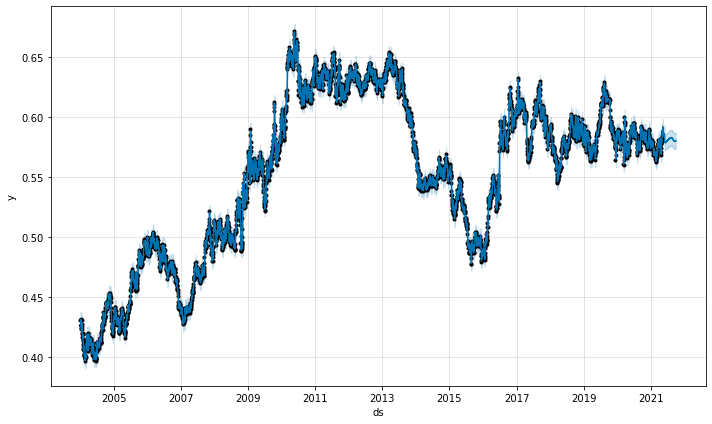

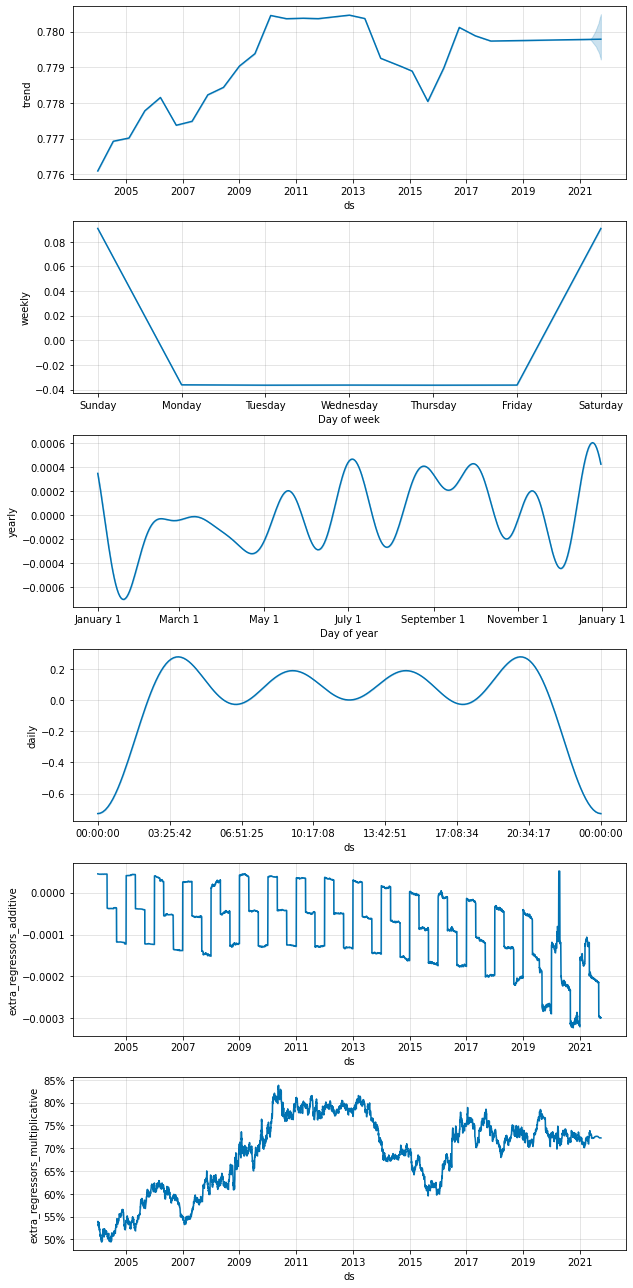

In [110]:
gbp_daily_plot = model_gbp_daily.plot(forecast_gbp_daily)
print(gbp_daily_plot);
print(model_gbp_daily.plot_components(forecast_gbp_daily));

In [111]:
## check metrics (Train: 206 months = 4298 business days, Test: 5 months = 106 days) 
## Ref: https://www.timeanddate.com/date/workdays.html?d1=01&m1=03&y1=2004&d2=01&m2=01&y2=2021&ti=on&

## Following code takes time to process - run only if needed.

# cv_results_gbp_daily = cross_validation(model=model_gbp_daily, initial = '4298 days', horizon = '109 days') 
# gbp_daily_performance = performance_metrics(cv_results_gbp_daily)
# gbp_daily_performance

INFO:fbprophet:Making 36 forecasts with cutoffs between 2015-10-22 12:00:00 and 2021-01-11 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]

horizon       mse      rmse       mae      mape     mdape  \
0    11 days 00:00:00  0.000009  0.002985  0.002312  0.004020  0.003336   
1    11 days 12:00:00  0.000009  0.002974  0.002302  0.004001  0.003374   
2    12 days 00:00:00  0.000009  0.002949  0.002280  0.003963  0.003336   
3    12 days 12:00:00  0.000008  0.002914  0.002265  0.003936  0.003296   
4    13 days 00:00:00  0.000009  0.002945  0.002303  0.003996  0.003374   
..                ...       ...       ...       ...       ...       ...   
192 107 days 00:00:00  0.000010  0.003165  0.002396  0.004147  0.003279   
193 107 days 12:00:00  0.000010  0.003122  0.002359  0.004087  0.003247   
194 108 days 00:00:00  0.000010  0.003101  0.002345  0.004060  0.003180   
195 108 days 12:00:00  0.000010  0.003231  0.002373  0.004111  0.003180   
196 109 days 00:00:00  0.000011  0.003267  0.002398  0.004147  0.003154   

     coverage  
0    0.957143  
1    0.957143  
2    0.957440  
3    0.960714  
4    0.960714  
..        ...  
192  0.953571  
193  0.954762  
194  0.953571  
195  0.947253  
196  0.946429  

[197 rows x 7 columns]

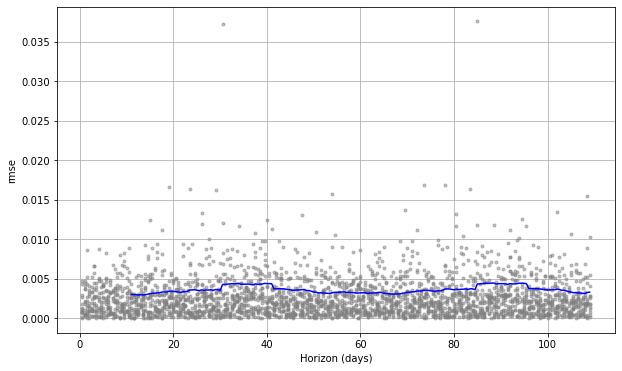

In [112]:
residualplot_gbp_daily_testdays = plot_cross_validation_metric(cv_results_gbp_daily, metric='rmse')

<AxesSubplot:ylabel='Density'>

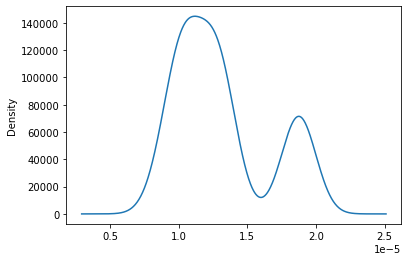

In [113]:
gbp_daily_performance['mse'].plot(kind='kde') ## Residuals are bimodal

In [114]:
multivariate_gbp_daily_test = pd.DataFrame(forecast_gbp_daily.ds[-109:].reset_index(drop=True))
multivariate_gbp_daily_test['Actual'] = test_gbp_daily['y'].reset_index(drop=True)
multivariate_gbp_daily_test['Predicted'] = forecast_gbp_daily[-109:]['yhat'].reset_index(drop=True)

In [115]:
multivariate_gbp_daily_test[20:]

ds    Actual  Predicted
20  2021-05-31  0.578874   0.584086
21  2021-06-01  0.578771   0.583047
22  2021-06-02  0.578720   0.578893
23  2021-06-03  0.578705   0.578670
24  2021-06-04  0.578693   0.578671
..         ...       ...        ...
104 2021-09-24  0.579389   0.579787
105 2021-09-27  0.579386   0.580041
106 2021-09-28  0.579368   0.579792
107 2021-09-29  0.579395   0.579881
108 2021-09-30  0.579425   0.579775

[89 rows x 3 columns]

In [125]:
## Export pickle file for this model
pickle.dump(model_gbp_daily,open('../Saved_Models_Pickle/model_gbp_daily.pkl','wb'))